## 0001145280

## Farneti Francesco

## francesco.farneti7@studio.unibo.it

# **Machine Learning for Computer Vision Assignment**
## A.Y. 2024–2025.

# Methodology Overview: Open‑World Semantic Segmentation

The system is built to perform **open‑world semantic segmentation**, meaning it must both correctly segment *in‑distribution* classes and detect *out‑of‑distribution (OOD)* pixels. This is achieved by combining a **close‑set segmentation module** with an **anomaly segmentation module**.

---

### 1. Close‑set Segmentation via Metric Learning

We adopt a deep metric learning network (DMLNet) that replaces the traditional classifier with a prototype‑based metric representation. Let:

$$
\mathcal{M}_{in} = \{ m_t \in \mathbb{R}^{1xN} \mid t \in \{1, \dots, N\} \}
$$

be the set of prototypes for the $N$ known in‑distribution classes. The network feature extractor $f(X; \theta_f)$ maps each pixel $X_{i,j}$ into a feature vector of dimension $1xN$.

The probability that pixel $(i,j)$ belongs to class $t$ is defined by a softmax over negative Euclidean distances:

$$
p_t(X_{i,j}) = \frac{\exp\bigl(-\|f(X; \theta_f)_{i,j} - m_t\|^2\bigr)}{\sum_{k=1}^N \exp\bigl(-\|f(X; \theta_f)_{i,j} - m_k\|^2\bigr)}
$$

The **close‑set segmentation map** is then:

$$
\hat Y^{\text{close}}_{i,j} = \arg\max_{t} \; p_t(X_{i,j})
$$

The training loss is a hybrid combining:

* **Discriminative Cross‑Entropy (DCE) Loss**:
$$
    L_{DCE} = \sum_{i,j} -\log \frac{\exp\!\bigl(-\|f(X; \theta_f)_{i,j} - m_{Y_{i,j}}\|^2\bigr)}{\sum_{k=1}^N \exp\!\bigl(-\|f(X; \theta_f)_{i,j} - m_k\|^2\bigr)}
$$
    This enforces attraction to the correct prototype and repulsion from others.

* **Variance Loss (VL)**:
$$
    L_{VL} = \sum_{i,j} \| f(X; \theta_f)_{i,j} - m_{Y_{i,j}} \|^2
$$
    This encourages compactness around the correct prototype.

**Overall loss:**

$$
L = L_{DCE} + \lambda_{VL}\, L_{VL}
$$

where $\lambda_{VL}$ is a hyperparameter.

---

### 2. Anomaly Segmentation (OOD Detection)

To detect OOD pixels, the system produces an **anomaly probability map** $\hat P \in [0,1]^{H \times W}$ using two complementary criteria:

**1. Maximum Softmax Probability (MMSP)** — interpreted in metric space:

$$
\hat P^{MMSP}_{i,j} = 1 - \max_{t\in\{1,\dots,N\}} p_t(X_{i,j})
$$

**2. Euclidean Distance Sum (EDS)**:

$$
S(X_{i,j}) = \sum_{t=1}^N \|f(X; \theta_f)_{i,j} - m_t\|^2
$$

$$
\hat P^{EDS}_{i,j} = 1 - \frac{S(X_{i,j})}{\max_{i',j'} S(X_{i',j'})}
$$

Because EDS is class‑independent, prototypes must be fixed (e.g. as one-hot vectors) and evenly distributed; updating them during training can destabilize OOD detection.

To reduce false positives (e.g. pixels with intermediate responses), MMSP and EDS are **fused**:

$$
\hat P = \alpha \,\hat P^{EDS} + (1 - \alpha)\,\hat P^{MMSP}
$$

with:

$$
\alpha = \frac{1}{1 + \exp\bigl(-\beta (\hat P^{EDS} - \gamma)\bigr)}
$$

where $\beta, \gamma$ are hyperparameters controlling the blending / suppression behavior.


## Alternative Training and Anomaly Detection Approach

In addition to the solution proposed in the primary paper, an alternative strategy was experimented with. This approach focuses exclusively on the **training loss function** and **anomaly detection mechanism**, while keeping the underlying model architecture unchanged.

---

### 1. Cosine Similarity-based Loss Function

The loss function adopted here is inspired by **ArcFace/CosFace**, but implemented **without the angular margin**. The objective is to evaluate the effectiveness of training focused on angular separation between class prototypes, rather than the Euclidean distance used in the original method.



**Mechanism:**

1.  **Normalization**: Both the pixel feature vectors $f(X)_{i,j}$ and the class prototypes $m_t$ are $L_2$ normalized along the channel dimension to obtain unit vectors:
  $$
    \hat{f}_{i,j} = \frac{f(X)_{i,j}}{\|f(X)_{i,j}\|}, \quad \hat{m}_t = \frac{m_t}{\|m_t\|}
  $$

2.  **Cosine Similarity**: The similarity is calculated via the dot product, resulting in values within the range $[-1, 1]$:
  $$
    \cos(\theta_t) = \hat{f}_{i,j} \cdot \hat{m}_t
  $$

3.  **Scaling**: The cosine similarity is multiplied by a fixed **scale factor** $s$. This "spreads" the distribution of the logits before applying Softmax:
  $$
    \text{logits}_t = s \cdot (\hat{f}_{i,j} \cdot \hat{m}_t)
  $$

4.  **Optimization**: The standard **Cross Entropy Loss** is computed on these scaled logits. This forces the features to be as close as possible to the correct prototype in terms of angular direction, and orthogonal (or opposite) to other prototypes.

---

### 2. Anomaly Detection Strategy

To detect Out-of-Distribution (OOD) pixels, a simple metric based on the same cosine similarities was introduced:

$$
\text{anomaly score }_{i,j} = 1 - \max_{t=1 \dots N} \bigl( \cos(\hat{f}_{i,j}, \hat{m}_t) \bigr)
$$

**Interpretation:**

- For each pixel, its embedding ${f}_{i,j}$ is compared to all class prototypes, and the **closest prototype** (highest cosine similarity) is selected.  
- If the pixel embedding is well aligned with this nearest prototype (cosine similarity close to 1), it indicates a **confident, in-distribution prediction** (low anomaly score).  
- If, even with the nearest prototype, the embedding is still far (low or negative cosine similarity), it suggests that the pixel is **directionally far from all known classes** (high anomaly score).

---

### References

* **Original Approach**: *L. H. Liu et al., *Open‑World Semantic Segmentation via Metric‑based Anomaly Detection*,* [arXiv:2108.04562.](https://arxiv.org/abs/2108.04562)
* **ArcFace**: Deng, J., et al. (2019). *ArcFace: Additive Angular Margin Loss for Deep Face Recognition.* [arXiv:1801.07698](https://arxiv.org/abs/1801.07698) and **CosFace**: Wang, F., et al. (2018).
* **CosFace**: *Large Margin Cosine Loss for Deep Face Recognition.* [arXiv:1801.09414](https://arxiv.org/abs/1801.09414)



In [ ]:
pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.5 MB/s eta 0:00:00


Imports

In [ ]:
import os
import glob
import gc
import zipfile
import random
import re
from typing import Tuple, Dict, Any
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix, average_precision_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.transforms import InterpolationMode
import segmentation_models_pytorch as smp
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.ndimage import mean as nd_mean
import gdown
from collections import defaultdict
import traceback
from tabulate import tabulate

# 1. DATA

Data download (if the current file_id doesn't work, use the other one)

In [ ]:
#file_id = "1DuPTKtukR-KE-B0lP39vB_0rR_LwyFN8"
file_id = "17tUEsKDFskiCpACBid0HX0RvsocpwOqa"
zip_path_training = "streetHazards_train.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path_training, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=17tUEsKDFskiCpACBid0HX0RvsocpwOqa
From (redirected): https://drive.google.com/uc?id=17tUEsKDFskiCpACBid0HX0RvsocpwOqa&confirm=t&uuid=f6dca6f5-b0dd-4950-a1f1-f677cd8ae3f1
To: /content/streetHazards_train.zip
100%|██████████| 9.37G/9.37G [02:05<00:00, 74.9MB/s]


'streetHazards_train.zip'

In [ ]:
#file_id = "1Jy6GzG70iS9wA1yS9PuLtchjCXucOvHd-X"
file_id = "1CBfZUXQvnuvIlrjrZyLsL633JYbsWv-X"
zip_path_test = "streetHazards_test.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path_test, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CBfZUXQvnuvIlrjrZyLsL633JYbsWv-X
From (redirected): https://drive.google.com/uc?id=1CBfZUXQvnuvIlrjrZyLsL633JYbsWv-X&confirm=t&uuid=65279e10-93d0-4b75-a353-3faad353815c
To: /content/streetHazards_test.zip
100%|██████████| 2.14G/2.14G [00:27<00:00, 77.9MB/s]


'streetHazards_test.zip'

In [ ]:
extract_path = '/content/dataset/StreetHazards'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path_training, 'r') as zip_ref:
    files = zip_ref.namelist()
    for file in tqdm(files, desc="Estrazione ZIP"):
        zip_ref.extract(file, extract_path)
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
    files = zip_ref.namelist()
    for file in tqdm(files, desc="Estrazione ZIP"):
        zip_ref.extract(file, extract_path)

Estrazione ZIP: 100%|██████████| 3012/3012 [00:24<00:00, 125.25it/s]


Data preparation

In [ ]:
class StreetHazardsDataset(Dataset):
    def __init__(self, image_root, mask_root, transform=None, target_transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_root, '**', '*.*'), recursive=True))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_root, '**', '*.*'), recursive=True))
        assert len(self.image_paths) == len(self.mask_paths), \
            f"Numero immagini ({len(self.image_paths)}) e maschere ({len(self.mask_paths)}) diverso!"
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        original_size = image.size  # (W, H)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
            mask = mask.squeeze(0).to(torch.int64)
            mask = mask - 1

        return image, mask, original_size # this is because, in the early stages of the project, I had considered a strategy that used images with reduced dimensions.

In [ ]:
# === transforms ===
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.PILToTensor()
])

# === dataset paths ===
train_base = '/content/dataset/StreetHazards/streethazards_train/train'
train_imgs = os.path.join(train_base, 'images/training')
train_masks = os.path.join(train_base, 'annotations/training')
val_imgs = os.path.join(train_base, 'images/validation')
val_masks = os.path.join(train_base, 'annotations/validation')

test_base = '/content/dataset/StreetHazards/streethazards_test/test'
test_imgs = os.path.join(test_base, 'images/test')
test_masks = os.path.join(test_base, 'annotations/test')

# === Dataset ===
train_dataset = StreetHazardsDataset(train_imgs, train_masks, image_transform, mask_transform)
val_dataset = StreetHazardsDataset(val_imgs, val_masks, image_transform, mask_transform)
test_dataset = StreetHazardsDataset(test_imgs, test_masks, image_transform, mask_transform)

# === DataLoader ===
seed = 42
g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, generator=g)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=1, generator=g)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=1, generator=g)


Data Exploration

![resnet cos scale factor = 5.5](https://drive.google.com/uc?id=1irr4MFDMRP-37ofIQgq3DDjLIC6H-r8a)

Looking at the class distribution, it is clear that the dataset is strongly unbalanced: very frequent classes such as Road or Building cover most of the pixels, while classes like Pedestrian, Traffic Sign, or Car appear only in a very small percentage.

This imbalance creates two main problems for our system.
First, it affects the Closed-Set Segmentation Module, because the model struggles to learn good representations of the rare classes, which therefore get a lower IoU.
Second, it also influences the Anomaly Detection Module: since it relies on the model’s confidence, a known class with very few examples tends to produce more uncertain predictions. As a result, the system may wrongly treat these pixels as anomalies, creating false positives that come from the poor representation of the rare classes rather than from real OOD elements.

In [ ]:
# @title Visualization
PALETTE = [
    (135, 206, 235),   # 0: unlabeled - sky blue
    (169, 169, 169),   # 1: building - dark light gray (dark gray)
    (128, 0, 128),     # 2: fence - purple
    (0, 0, 255),       # 3: other (various objects) - blue
    (255, 255, 0),     # 4: pedestrian - bright yellow
    (0, 0, 0),         # 5: pole - black
    (255, 255, 255),   # 6: road line - white
    (50, 50, 50),      # 7: road - dark asphalt gray
    (101, 67, 33),     # 8: sidewalk - dark brown
    (0, 100, 0),       # 9: vegetation - dark green
    (0, 255, 0),       # 10: car - neon green
    (184, 134, 11),    # 11: wall - dark ochre (brown-yellow ochre mix)
    (255, 165, 0),     # 12: traffic sign - classic orange
    (255, 0, 0),       # 13: anomaly - bright red
]

CLASS_NAMES = [
    'unlabeled', 'builiding', 'fence',
    'other', 'pedestrian', 'pole', 'road line', 'road',
    'sidewalk', 'vegetation', 'car', 'wall','traffic sign', 'anomaly'
]

PALETTE = np.array(PALETTE) / 255.0
cmap = ListedColormap(PALETTE)

legend_elements = [
    Patch(facecolor=PALETTE[i], edgecolor='black', label=CLASS_NAMES[i])
    for i in range(len(CLASS_NAMES))
]

def show_legend():
    plt.figure(figsize=(5,1.5))
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='center', ncol=4, fontsize='medium')
    plt.title("StreetHazards class legend", fontsize=14)
    plt.show()

def denormalize(tensor_img):
    """Denormalizza un tensore immagine normalizzato con mean/std ImageNet"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor_img * std + mean

def show_samples(data_loader, title, num_samples=8):
    plt.figure(figsize=(20, 6 * num_samples))
    for i, (images, masks, _) in enumerate(data_loader):
        batch_size = images.size(0)
        samples_to_show = min(num_samples, batch_size)
        for j in range(samples_to_show):
            image = denormalize(images[j]).permute(1, 2, 0).cpu().numpy()
            image = np.clip(image, 0, 1)
            mask = masks[j].cpu().numpy()

            unique_classes = np.unique(mask)
            class_names_in_mask = [CLASS_NAMES[int(c)] for c in unique_classes if 0 <= c < len(CLASS_NAMES)]

            plt.subplot(samples_to_show, 2, j*2 + 1)
            plt.imshow(image)
            plt.title(f"{title} Image {j+1}", fontsize=12)
            plt.axis('off')

            plt.subplot(samples_to_show, 2, j*2 + 2)
            plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(CLASS_NAMES) - 1)
            plt.title(f"{title} Mask {j+1}\nClasses: {', '.join(class_names_in_mask)}", fontsize=10)
            plt.axis('off')
        break  # just first batch
    plt.tight_layout()
    plt.show()

show_legend()
show_samples(train_loader, title="Train", num_samples=2)
show_samples(test_loader, title="Test", num_samples=2)

# 2. MODELS, TRAINING AND ABLATION STUDIES

At the end of the notebook, screenshots are provided illustrating the training progress of the models across the different configurations discussed and the code used for training is included

Model's weights download

In [ ]:
files = {
    "resnet101.pth":    "https://drive.google.com/file/d/16NINmxIZYTgGW6siXrFQinieXNDTN7CU/view?usp=drive_link",
    "resnext.pth":      "https://drive.google.com/file/d/1XNo-4rMDV2IJL13f8vcrAi2TXdnq00Z-/view?usp=drive_link",
    "mobilenet_v2.pth": "https://drive.google.com/file/d/1Kd01IN8ThAQgxDrTsbA2JxeHUjl5nIbZ/view?usp=drive_link",
    "group_norm.pth":   "https://drive.google.com/file/d/1SOU6fxwwtWa44b-VXD44ZiaKacFDjiR2/view?usp=drive_link",
    "prototipo_1.pth":  "https://drive.google.com/file/d/1p53BIwOIMAITpRMVSaOuUcjhR2ypjYbT/view?usp=drive_link",
    "prototipo_5.pth":  "https://drive.google.com/file/d/1stTbisBvaYFC35vDZMSY141GmxuOhgWe/view?usp=drive_link",
    "cos_20.pth":       "https://drive.google.com/file/d/1UoiQryJ5WpOuXXVERn28TZy_9oY1c2RW/view?usp=drive_link",
    "cos_10.pth":       "https://drive.google.com/file/d/1RTpBM0eBsERkwMKNnDdn_UNPfdT1-7jm/view?usp=drive_link",
    "cos_margin_10.pth":"https://drive.google.com/file/d/1EwcFHw7eYykCcfks9kaYPwVFogdui228/view?usp=drive_link"
}

for output_name, url in files.items():
    print(f"{output_name}...")
    if os.path.exists(output_name):
        os.remove(output_name)

    gdown.download(url, output=output_name, quiet=False, fuzzy=True)

resnet101.pth...


Downloading...
From (original): https://drive.google.com/uc?id=16NINmxIZYTgGW6siXrFQinieXNDTN7CU
From (redirected): https://drive.google.com/uc?id=16NINmxIZYTgGW6siXrFQinieXNDTN7CU&confirm=t&uuid=b049fc37-5dcc-42b3-8dcd-32e7eb446c1c
To: /content/resnet101.pth
100%|██████████| 174M/174M [00:03<00:00, 46.0MB/s]


resnext.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1XNo-4rMDV2IJL13f8vcrAi2TXdnq00Z-
From (redirected): https://drive.google.com/uc?id=1XNo-4rMDV2IJL13f8vcrAi2TXdnq00Z-&confirm=t&uuid=9c489a5f-2776-4958-b045-b24de4b3ca58
To: /content/resnext.pth
100%|██████████| 106M/106M [00:01<00:00, 53.4MB/s] 


mobilenet_v2.pth...


Downloading...
From: https://drive.google.com/uc?id=1Kd01IN8ThAQgxDrTsbA2JxeHUjl5nIbZ
To: /content/mobilenet_v2.pth
100%|██████████| 9.54M/9.54M [00:00<00:00, 14.3MB/s]


group_norm.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1SOU6fxwwtWa44b-VXD44ZiaKacFDjiR2
From (redirected): https://drive.google.com/uc?id=1SOU6fxwwtWa44b-VXD44ZiaKacFDjiR2&confirm=t&uuid=eb7521b9-6f2d-49cd-a91c-7a2adf339e10
To: /content/group_norm.pth
100%|██████████| 174M/174M [00:03<00:00, 53.0MB/s]


prototipo_1.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1p53BIwOIMAITpRMVSaOuUcjhR2ypjYbT
From (redirected): https://drive.google.com/uc?id=1p53BIwOIMAITpRMVSaOuUcjhR2ypjYbT&confirm=t&uuid=57fe430e-4681-4f29-b2ae-fde2686f6b12
To: /content/prototipo_1.pth
100%|██████████| 174M/174M [00:02<00:00, 58.3MB/s]


prototipo_5.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1stTbisBvaYFC35vDZMSY141GmxuOhgWe
From (redirected): https://drive.google.com/uc?id=1stTbisBvaYFC35vDZMSY141GmxuOhgWe&confirm=t&uuid=aad91781-e47c-4b01-a511-4b5a6258e5b3
To: /content/prototipo_5.pth
100%|██████████| 174M/174M [00:02<00:00, 59.0MB/s]


cos_20.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1UoiQryJ5WpOuXXVERn28TZy_9oY1c2RW
From (redirected): https://drive.google.com/uc?id=1UoiQryJ5WpOuXXVERn28TZy_9oY1c2RW&confirm=t&uuid=41ed7f30-e751-4b09-b14c-da2bbfe41ba1
To: /content/cos_20.pth
100%|██████████| 174M/174M [00:04<00:00, 35.0MB/s]


cos_10.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1RTpBM0eBsERkwMKNnDdn_UNPfdT1-7jm
From (redirected): https://drive.google.com/uc?id=1RTpBM0eBsERkwMKNnDdn_UNPfdT1-7jm&confirm=t&uuid=060949c7-6092-466f-8807-b6327640c3da
To: /content/cos_10.pth
100%|██████████| 174M/174M [00:02<00:00, 64.0MB/s]


cos_margin_10.pth...


Downloading...
From (original): https://drive.google.com/uc?id=1EwcFHw7eYykCcfks9kaYPwVFogdui228
From (redirected): https://drive.google.com/uc?id=1EwcFHw7eYykCcfks9kaYPwVFogdui228&confirm=t&uuid=911d3d6e-f359-4994-9ae1-ad7aa42094cd
To: /content/cos_margin_10.pth
100%|██████████| 174M/174M [00:03<00:00, 53.5MB/s]


# Metric Learning-Based Model

## 1) Choice Not to Replicate Paper Ablation Studies
I did not replicate all the ablation studies presented in the paperwhere the original approach is presented [arXiv:2108.04562.](https://arxiv.org/abs/2108.04562), as they were already addressed and discussed by the authors.  
I preferred to focus my time and computational resources on new observations and more practical aspects, particularly on adapting the pipeline to a context with computational constraints and the need for real-time inference.

---

## 2) Implementation of the Paper's Pipeline


All experiments relied on models provided by the **segmentation_models_pytorch (smp)** library, both for the architectures and for the evaluation metrics, specifically the IoU statistics.

Following the reference paper, the baseline architecture consists of a **PSPNet** decoder ([Zhao et al., 2017](https://arxiv.org/abs/1612.01105)) coupled with a **ResNet-101** backbone. This setup serves as the starting point for all subsequent experiments and ablation studies.

In this configuration:
* **ResNet-101** acts as the *feature extractor*.
* **PSPNet** functions as the *decoder*, responsible for aggregating multi-scale contextual information before producing the final segmentation map.

### **Pyramid Scene Parsing Network (PSPNet)**

PSPNet is designed to capture both local and global context by introducing a **pyramid pooling module**.

1.  This module applies pooling operations at various spatial scales on the high-level feature maps produced by the backbone.
2.  The resulting features are then upsampled to the original resolution.
3.  Finally, they are concatenated with the initial feature map to form the final representation.

I implemented the pipeline defined in the paper with one substantial difference regarding the training scheme.  
In the paper, the model is trained for 20 epochs using:

- **SGD** with momentum 0.9  
- **Learning rate = 2×10⁻²**  
- **Weight decay = 10⁻⁴**

In my case, replicating this configuration was challenging due to limited resources (the models were trained on Kaggle).  
To allow training to **converge within a limited number of epochs**, I adopted:

- **Learning rate = 1e-4**  
- **Weight decay = 0.01** (adapted to AdamW)
- **AdamW** optimizer  
- **ReduceLROnPlateau** with factor 0.25-0.5 and patience 0  
- **Early stopping** after 3-4 epochs
- **Batch size = 4**

The learning rate choice was determined experimentally:  

- 5e-4: slight instability toward convergence, often no real benefits (kept only the MobileNet training)  
- 5e-5: significantly slower training, no tangible advantages  

The same training scheme was also applied to the cosine similarity-based loss.

---

## 3) BatchNorm and GroupNorm

Another constraint was the decision to work with full-resolution images, where GPU memory allowed batch sizes of at most 4–8, depending on the model. BatchNorm is not designed to produce stable statistics with such small batches. Therefore, I applied a BatchNorm → GroupNorm conversion, which does not depend on batch size.
- **32 groups** for most feature maps ([Wu & He, ECCV 2018](https://arxiv.org/abs/1803.08494))  
- **Automatic fallback** for layers with few features

The motivation for trying **GroupNorm** comes from the experiments reported in the original paper by [Wu & He, ECCV 2018](https://arxiv.org/abs/1803.08494). In that study:

- The authors evaluated **ResNet-50** on ImageNet using different normalization methods (BN, LN, IN, GN).  
- They varied batch sizes from 32 down to 2 images per GPU.  
- Results showed that while **BN’s performance degraded significantly** with very small batches (e.g., top-1 error increased from 23.6% to 34.7% for batch size 2), **GN remained stable and largely insensitive to batch size**, achieving much lower error under the same conditions.

---

## 4) Prototype Scaling
Another design choice concerns the scaling of prototypes, the value used to construct the one-hot vectors representing the classes.  
The goal was to observe how different prototype magnitudes influence the feature geometry, without changing the feature space dimensionality.
- Paper: **T = 3**  
- My experiments: **T = 1** and **T = 5**

---

## 5) Choice of Lighter Models for Real-Time Inference
In the context of the task, the choice of lightweight architectures can be a key requirement, especially when inference needs to be performed in very short times and on devices with limited hardware resources.
In such scenarios, even a highly accurate model loses much of its usefulness if it cannot operate quickly enough.

For this reason, in this work I considered two backbones lighter than the baseline, each motivated by specific needs:

- **MobileNetV2** was chosen for its extremely lightweight design, optimized for low-power devices. It is particularly suitable for testing the pipeline under realistic conditions with strict hardware constraints, such as those typical of embedded or real-time systems.

- **SE-ResNeXt-50 (32×4d)**, on the other hand, represents a more balanced solution: it is lighter than a ResNet-101, yet still maintains comparable performance thanks to the combination of the ResNeXt architecture and Squeeze-and-Excitation modules. In this sense, it offers an effective compromise between accuracy and efficiency compared to the baseline.
---

## 6) Superpixel Post-Processing
I experimented with a post-processing step on the anomaly maps using a superpixel algorithm, inspired by the one used in selective search for defining region proposals.  

The goal was to reduce noise generated by small incoherent regions, often associated with false positives near edges or non-uniform segmentations.  
Superpixels aggregate pixels into homogeneous regions, regularizing the final mask, removing spurious areas, and making spatial predictions more coherent.


# Cosine similarity loss based model
## 1) Note about the scale factor
In cosine-based softmax methods, both the model features and the class prototypes are normalized, so the dot product produces values in the range $[-1, 1]$. Without an appropriate **scale factor ($s$)**, the softmax operates on very small logits, producing nearly uniform probabilities around $1/C$, which reduces the network's ability to distinguish between classes. In other words, the scale factor serves to "stretch" the logits, making the softmax more sensitive to differences among classes.

According to [Liu, H., et al. (2020)](https://arxiv.org/abs/1912.05814), there exists a recommended **minimum scale factor** based on the number of classes ($C$) and the expected angle between features and non-target class prototypes. Considering a reference angle ($\theta_0 = \pi/4$), which lies in the middle of the interval $[0, \pi/2]$ where probabilities begin to provide meaningful supervision for backpropagation, a fixed minimum scale factor can be estimated as:

\begin{equation}
s_{\min} \approx \frac{\log B_i}{\cos(\pi/4)} \approx \sqrt{2} \cdot \log(C-1)
\end{equation}

where

\begin{equation}
B_i = \sum_{k \neq y_i} e^{s \cdot \cos \theta_{i,k}}
\end{equation}

represents the sum of logits of non-target classes. During training, the angles $\theta_{i,k}$ for incorrect classes tend to remain close to $\pi/2$, so $e^{s \cdot \cos \theta_{i,k}} \approx 1$, which simplifies the estimate to $B_i \approx C-1$. This ensures that classification probabilities are in a useful range and that gradients do not vanish for difficult pixels. For my case with 13 classes, this gives $s_{\min} \approx 3.5$.

The choice of scale factor directly influences both the predicted probabilities and the gradient magnitude:

* **Low scale factor** (e.g., near the minimum) produces moderate probabilities even for easy pixels and stable gradients: the network receives a steady signal but may require more epochs to separate similar classes. For instance, a pixel clearly belonging to the correct class may have only $\sim 50%$ probability and a modest gradient, pushing the network to “work harder” to strengthen the separation.

* **High scale factor** (e.g., 20–30) results in probabilities for easy pixels close to 1 and very large gradients for ambiguous pixels: this accelerates learning on clear cases but risks **saturation of easy pixels** and **numerical instability**. For example, an ambiguous pixel between two similar classes could produce very large gradients, while an already correct pixel may have a probability near 1 and provide almost no useful gradient for updating the network.

Based on these considerations, I selected $s=10$ and $s=20$. The first choice represents a moderate approach (sufficiently higher than the theoretical minimum ($s_{min} \approx 3.5$)) while the other onw was chosen to represent a more aggressive strategy.

---

## 2) Training using margin

To encourage better clustering of classes, it is well known that a **margin** can be introduced to penalize predictions, pushing pixel embeddings closer to their corresponding prototypes, as done in ArcFace or CosFace methods. Initially, I implemented training using ArcFace penalty, but in this case the loss proved unstable, a problem also highlighted in [arXiv:1912.05814](https://arxiv.org/abs/1912.05814), where it is noted that the margin parameter $m$ is highly sensitive and requires careful tuning.

Switching to CosFace penalty, however, allowed the margin to be added while keeping training stable and consistent. The main difference lies in the application of the penalty: **while ArcFace adds an angular margin inside the cosine function ($\theta + m$), CosFace subtracts the margin directly from the cosine value ($\cos \theta - m$).** This results in the following objective function for CosFace:

$$
L_{CosFace} = -\log \frac{e^{s(\cos(\theta_{y_i}) - m)}}{e^{s(\cos(\theta_{y_i}) - m)} + \sum_{j \neq y_i} e^{s \cos(\theta_j)}}
$$

where $\theta_{y_i}$ is the angle between the feature vector and the ground truth class prototype, $m$ is the margin, and $s$ is the scaling parameter.

The chosen margin value is **$m = 0.1$**, as it represents a balanced penalization that can impact training without drastically altering the baseline behavior. To provide an intuitive sense of the effect of this value, the maximum allowed angles $\theta_y$ for the target class are reported for some typical cosine similarities with non-target classes ($\cos \theta_j$):

1. **Non-target cosine $\cos \theta_j = -0.5$**  
   Threshold: $\cos \theta_y > \cos \theta_j + m = -0.5 + 0.1 = -0.4$  
   Maximum allowed angle: $\theta_y < \arccos(-0.4) \approx 113.58^\circ$  
   The constraint is practically negligible, the non-target is pointing in almost the opposite direction.

2. **Non-target cosine $\cos \theta_j = 0.0$**  
   Threshold: $\cos \theta_y > 0.0 + 0.1 = 0.1$  
   Maximum allowed angle:  $arccos(0.1) \approx 84.26^\circ$  
   Weak constraint

3. **Non-target cosine $\cos \theta_j = 0.5$**  
   Threshold: $\cos \theta_y > 0.5 + 0.1 = 0.6$  
   Maximum allowed angle:  $arccos(0.6) \approx 53.13^\circ$  
   Moderate constraint, the target embedding must be closer enough to its prototype than to the competing class

4. **Non-target cosine $\cos \theta_j = 0.8$**  
   Threshold: $\cos \theta_y > 0.8 + 0.1 = 0.9$  
   Maximum allowed angle: $arccos(0.9) \approx 25.84^\circ$  
   Strong constraint; the target embedding must be very tightly aligned with its prototype

Since the margin effectively increases the difficulty of the task by shifting the decision boundary, combining it with an aggressive scale factor (e.g., $s=20$) could risk destabilizing the training dynamics, so for this study i chose to fix $s=10$.

---

**References:**

- Liu, H., et al. (2020). *AdaCos: Adaptively Scaling Cosine Logits for Effectively Learning Deep Face Representations.* [arXiv:1912.05814](https://arxiv.org/abs/1912.05814)





In [ ]:
N = 13
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_configs: Dict[str, Dict[str, Any]] = {
    "resnet101":    {"encoder": "resnet101",          "weights_path": "/content/resnet101.pth",    "use_groupnorm": False, "prototype_type": "T", "scale_factor": None},
    "resnext":      {"encoder": "se_resnext50_32x4d", "weights_path": "/content/resnext.pth",      "use_groupnorm": False, "prototype_type": "T", "scale_factor": None},
    "mobilenet_v2": {"encoder": "mobilenet_v2",       "weights_path": "/content/mobilenet_v2.pth", "use_groupnorm": False, "prototype_type": "T", "scale_factor": None},
    "group_norm":   {"encoder": "resnet101",          "weights_path": "/content/group_norm.pth",   "use_groupnorm": True,  "prototype_type": "T", "scale_factor": None},
    "prototipo_1":  {"encoder": "resnet101",          "weights_path": "/content/prototipo_1.pth",  "use_groupnorm": False, "prototype_type": "T", "T": 1.0, "scale_factor": None},
    "prototipo_5":  {"encoder": "resnet101",          "weights_path": "/content/prototipo_5.pth",  "use_groupnorm": False, "prototype_type": "T", "T": 5.0, "scale_factor": None},

    "cos_margin_10":{"encoder": "resnet101",   "weights_path": "/content/cos_margin_10.pth",  "use_groupnorm": False, "prototype_type": "cos", "scale_factor": 10},
    "cos_10":       {"encoder": "resnet101",   "weights_path": "/content/cos_10.pth",         "use_groupnorm": False, "prototype_type": "cos", "scale_factor": 10.0},
    "cos_20":       {"encoder": "resnet101",   "weights_path": "/content/cos_20.pth",         "use_groupnorm": False, "prototype_type": "cos", "scale_factor": 20.0},
}

def create_model(encoder_name: str, classes: int = N, encoder_weights: str = None) -> nn.Module:
    """
    Create and return a PSPNet model (logits output, activation=None).
    """
    model = smp.PSPNet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=3,
        classes=classes,
        activation=None
    )
    return model

def load_state_dict_cpu(weight_path: str) -> dict:
    """
    Load a state dict from disk mapping it to CPU.
    """
    state = torch.load(weight_path, map_location="cpu", weights_only=False)
    return state

def get_prototypes_for_model(model_name: str, device: torch.device = DEVICE) -> Tuple[torch.Tensor, dict]:
    """
    Return a tuple (prototypes_tensor, meta) depending on model_name.
    - For prototype-type 'T' models: return (eye(N) * T, {"T": T})
    - For cos_* models: return (eye(N), {"scale_factor": value_extracted})
    Prototypes are created on CPU to avoid consuming GPU memory; move them to device later if needed.
    """
    cfg = model_configs.get(model_name, None)

    if cfg is None:
        T = 3.0
        return (torch.eye(N) * T, {"T": T})

    ptype = cfg.get("prototype_type", "T")

    if ptype == "T":
        T = float(cfg.get("T", 3.0))
        prototypes = torch.eye(N) * T
        return prototypes, {"T": T}

    elif ptype == "cos":
        m = re.search(r"cos[_-]?(\d+(?:\.\d+)?)", model_name)
        if m:
            scale = float(m.group(1))
        else:
            scale = float(cfg.get("scale_factor", 1.0))

        prototypes = torch.eye(N)
        return prototypes, {"scale_factor": scale}

    else:
        T = float(cfg.get("T", 3.0))
        prototypes = torch.eye(N) * T
        return prototypes, {"T": T}

# --- conversion BN->GN ---
def _adjust_num_groups(num_groups, num_channels):
    if num_groups <= 0:
        return 1
    if num_groups > num_channels:
        num_groups = num_channels
    while num_groups > 1 and (num_channels % num_groups != 0):
        num_groups -= 1
    return max(1, num_groups)

def convert_batchnorm_modules(module, num_groups=32, layer_norm=False):
    for name, child in list(module.named_children()):
        convert_batchnorm_modules(child, num_groups=num_groups, layer_norm=layer_norm)
        if isinstance(child, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            num_channels = child.num_features
            if layer_norm:
                ng = 1
            else:
                ng = _adjust_num_groups(num_groups, num_channels)
            gn = nn.GroupNorm(num_groups=ng, num_channels=num_channels, eps=child.eps, affine=True)
            if child.affine:
                with torch.no_grad():
                    if hasattr(child, 'weight') and child.weight is not None:
                        gn.weight.data.copy_(child.weight.data)
                        gn.weight.requires_grad = child.weight.requires_grad
                    if hasattr(child, 'bias') and child.bias is not None:
                        gn.bias.data.copy_(child.bias.data)
                        gn.bias.requires_grad = child.bias.requires_grad
            setattr(module, name, gn)

def convert_bn_to_gn(model: nn.Module, num_groups: int = 32, layer_norm: bool = False) -> nn.Module:
    convert_batchnorm_modules(model, num_groups=num_groups, layer_norm=layer_norm)
    return model

def build_model_configured(model_name: str, classes: int = N, encoder_weights: str = None, apply_groupnorm: bool = False) -> Tuple[nn.Module, str]:
    """
    Create the PSPNet model for `model_name` according to model_configs.
    Returns (model, weights_path). Model stays on CPU (not .to(DEVICE)).
    If the config requests GroupNorm conversion, it will be applied on CPU.
    Note: this function *does not* load the weights into the model (to avoid memory issues).
    """
    cfg = model_configs.get(model_name)
    if cfg is None:
        raise ValueError(f"No config found for model '{model_name}'. Available: {list(model_configs.keys())}")

    encoder = cfg["encoder"]
    weights_path = cfg["weights_path"]
    model = create_model(encoder_name=encoder, classes=classes, encoder_weights=encoder_weights)

    if apply_groupnorm or cfg.get("use_groupnorm", False):
        model = convert_bn_to_gn(model, num_groups=32, layer_norm=False)

    return model, weights_path

In [ ]:
# @title Legend for the model names reported in the experiments
data = [
    [1, "cos_10", "Cosine similarity-based model", "Scale factor = 10, no margin"],
    [2, "cos_margin_10", "Cosine similarity-based model with margin", "Scale factor = 10, includes margin = 0.1"],
    [3, "resnext", "SE-ResNeXt-50 (32×4d) backbone", "Lighter backbone"],
    [4, "prototipo_1", "ResNet101 backbone", "Prototype magnitude equal to 1"],
    [5, "cos_20", "Cosine similarity-based model", "Scale factor = 20, no margin"],
    [6, "resnet101", "ResNet101 backbone", "Baseline"],
    [7, "prototipo_5", "ResNet101 backbone", "Prototype magnitude equal to 5"],
    [8, "mobilenet_v2", "MobileNetV2 backbone", "Lighter backbone"],
    [9, "group_norm", "ResNet101 backbone", "Backbone uses Group Normalization instead of BatchNorm"]
]

# Intestazioni della tabella
headers = ["#", "Name", "Model / Configuration", "Notes / Description"]

# Stampa tabella
print(tabulate(data, headers=headers, tablefmt="grid"))


+-----+---------------+-------------------------------------------+--------------------------------------------------------+
|   # | Name          | Model / Configuration                     | Notes / Description                                    |
+=====+===============+===========================================+========================================================+
|   1 | cos_10        | Cosine similarity-based model             | Scale factor = 10, no margin                           |
+-----+---------------+-------------------------------------------+--------------------------------------------------------+
|   2 | cos_margin_10 | Cosine similarity-based model with margin | Scale factor = 10, includes margin = 0.1               |
+-----+---------------+-------------------------------------------+--------------------------------------------------------+
|   3 | resnext       | SE-ResNeXt-50 (32×4d) backbone            | Lighter backbone                                       |


# 3. CLOSED SET MODULE

## IoU

In [ ]:
"""
def pixel_accuracy(output, target):
    with torch.no_grad():
        if target.dtype != torch.long:
            target = target.long()
        preds = output.argmax(dim=1)
        valid = (target >= 0)
        correct = (preds == target) & valid
        acc = correct.sum().float() / valid.sum().float()
    return acc.item()
"""

def mean_iou(pred_mask, true_mask, num_classes, ignore_index=-1, return_per_class=False):

    if pred_mask.ndim == 4:  # logits [B, C, H, W]
        pred_mask = pred_mask.argmax(dim=1)

    TP, FP, FN, TN = smp.metrics.get_stats(
        output=pred_mask.long(),
        target=true_mask.long(),
        mode="multiclass",
        num_classes=num_classes,
        ignore_index=ignore_index
    )

    iou_per_class = smp.metrics.iou_score(TP, FP, FN, TN, reduction="none").mean(dim=0)

    valid = ~torch.isnan(iou_per_class)
    miou = iou_per_class[valid].mean().item()

    if return_per_class:
        return miou, iou_per_class
    return miou

## Results

In [ ]:
CLASS_NAMES = [
    'unlabeled', 'building', 'fence',
    'other', 'pedestrian', 'pole', 'road line', 'road',
    'sidewalk', 'vegetation', 'car', 'wall', 'traffic sign', 'anomaly'
]

# Computes pixel-wise class probabilities:
# 1) models based on euclidean distance: probabilities are softmax over negative Euclidean distances
#    p_t = softmax(-||f_i,j - m_t||^2)
# 2) models based on cosine similarity: probabilities are softmax over scaled cosine similarities
#    p_t = softmax(s * (f_i,j · m_t) / (||f_i,j|| ||m_t||))

def calculate_probabilities_dist(pixel_features, prototypes):
    """
    Calculates probabilities based on negative Euclidean distance (for 'T' models).
    """
    B, N, H, W = pixel_features.shape
    features_flat = pixel_features.permute(0, 2, 3, 1).reshape(-1, N)
    feat_sq = (features_flat**2).sum(dim=1, keepdim=True)
    proto_sq = (prototypes**2).sum(dim=1).unsqueeze(0)
    feat_dot_proto = torch.matmul(features_flat, prototypes.t())
    dists_sq = feat_sq - 2 * feat_dot_proto + proto_sq
    logits = -dists_sq
    probs_flat = F.softmax(logits, dim=1)
    probs = probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)
    return probs

def calculate_probabilities_cos(pixel_features, prototypes, scale_factor=20.0):
    """
    Calculates probabilities based on Cosine Similarity (for 'cos' models).
    """
    B, N, H, W = pixel_features.shape
    features_norm = F.normalize(pixel_features, p=2, dim=1)
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)
    cos_sim = torch.matmul(features_flat, prototypes_norm.t())
    logits = cos_sim * scale_factor
    probs_flat = F.softmax(logits, dim=1)
    probs = probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)
    return probs

In [ ]:
# @title Quantitative results
def benchmark_all_models_memory_safe(dataloader, device):
    results = {}

    for model_name, config in model_configs.items():
        print(f"--> Evaluating: {model_name}")

        model = None
        prototypes = None
        pixel_features = None
        total_miou = 0.0
        total_count = 0
        total_class_iou = torch.zeros(N, device=device)
        total_class_counts = torch.zeros(N, device=device)

        try:
            model, weights_path = build_model_configured(model_name, classes=N)
            state_dict = load_state_dict_cpu(weights_path)
            if config.get("use_groupnorm", False):
                keys_to_remove = [k for k in state_dict.keys() if
                                  "running_mean" in k or
                                  "running_var" in k or
                                  "num_batches_tracked" in k]
                if len(keys_to_remove) > 0:
                    for k in keys_to_remove:
                        del state_dict[k]

            try:
                model.load_state_dict(state_dict, strict=True)
            except RuntimeError as e:
                print(f"    Warning: Strict loading failed, retrying with strict=False.")
                model.load_state_dict(state_dict, strict=False)

            model.eval()

            prototypes, meta = get_prototypes_for_model(model_name)
            model = model.to(device)
            prototypes = prototypes.to(device)

            ptype = config.get("prototype_type", "T")
            scale_factor = meta.get("scale_factor", 1.0)

            # Validation Loop
            with torch.no_grad():
                for images, masks, _ in tqdm(dataloader, desc=f"Eval {model_name}", leave=False):
                    images = images.to(device)
                    masks = masks.to(device)

                    pixel_features = model(images)

                    if ptype == "cos":
                        probs = calculate_probabilities_cos(pixel_features, prototypes, scale_factor=scale_factor)
                    else:
                        probs = calculate_probabilities_dist(pixel_features, prototypes)

                    probs = F.interpolate(probs, size=masks.shape[1:], mode='bilinear', align_corners=False)
                    preds = torch.argmax(probs, dim=1)

                    batch_miou, batch_class_iou = mean_iou(preds, masks, num_classes=N, ignore_index=-1, return_per_class=True)

                    # 1. Update Global mIoU
                    if not torch.isnan(torch.tensor(batch_miou)):
                        total_miou += batch_miou * images.size(0)
                        total_count += images.size(0)

                    # 2. Update Class IoU
                    valid_classes = ~torch.isnan(batch_class_iou)
                    clean_batch_iou = torch.nan_to_num(batch_class_iou, nan=0.0).to(device)

                    total_class_iou += clean_batch_iou * images.size(0)
                    total_class_counts += valid_classes.float().to(device) * images.size(0)

            final_miou = total_miou / max(1, total_count)
            results[model_name] = final_miou

            final_class_iou = total_class_iou / (total_class_counts + 1e-6)

            print(f"    Result {model_name}: mIoU = {final_miou:.4f}")
            print(f"    Class-wise Details:")


            for i in range(N):

                if i < len(CLASS_NAMES):
                    c_name = CLASS_NAMES[i]
                else:
                    c_name = f"Class {i}"

                c_score = final_class_iou[i].item()


                if total_class_counts[i] == 0:
                    print(f"      {c_name:<15}: N/A (not present)")
                else:
                    print(f"      {c_name:<15}: {c_score:.4f}")
            print("-" * 40)

        except Exception as e:
            print(f"    CRITICAL ERROR with {model_name}: {e}")
            import traceback
            traceback.print_exc()
            results[model_name] = -1.0

        finally:
            # Memory Cleanup
            if model is not None: del model
            if prototypes is not None: del prototypes
            if pixel_features is not None: del pixel_features
            if 'probs' in locals(): del probs
            if 'images' in locals(): del images
            if 'masks' in locals(): del masks
            if 'total_class_iou' in locals(): del total_class_iou

            gc.collect()
            torch.cuda.empty_cache()

    print("\n" + "="*30)
    print("FINAL RANKING (mIoU)")
    print("="*30)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for i, (name, score) in enumerate(sorted_results):
        print(f"{i+1}. {name:<20}: {score:.4f}")

    return results

final_scores = benchmark_all_models_memory_safe(val_loader, DEVICE)

--> Evaluating: resnet101


    Result resnet101: mIoU = 0.5381
    Class-wise Details:
      unlabeled      : 0.8344
      building       : 0.6063
      fence          : 0.2470
      other          : 0.2770
      pedestrian     : 0.7121
      pole           : 0.1243
      road line      : 0.6309
      road           : 0.9151
      sidewalk       : 0.6180
      vegetation     : 0.7665
      car            : 0.6457
      wall           : 0.2370
      traffic sign   : 0.3808
----------------------------------------
--> Evaluating: resnext


    Result resnext: mIoU = 0.5493
    Class-wise Details:
      unlabeled      : 0.8539
      building       : 0.6223
      fence          : 0.3135
      other          : 0.1341
      pedestrian     : 0.7105
      pole           : 0.1749
      road line      : 0.6612
      road           : 0.9295
      sidewalk       : 0.6593
      vegetation     : 0.7929
      car            : 0.6602
      wall           : 0.2085
      traffic sign   : 0.4210
----------------------------------------
--> Evaluating: mobilenet_v2


    Result mobilenet_v2: mIoU = 0.5332
    Class-wise Details:
      unlabeled      : 0.8280
      building       : 0.5839
      fence          : 0.3026
      other          : 0.2765
      pedestrian     : 0.7282
      pole           : 0.1199
      road line      : 0.6217
      road           : 0.9197
      sidewalk       : 0.6626
      vegetation     : 0.7738
      car            : 0.5455
      wall           : 0.1687
      traffic sign   : 0.4004
----------------------------------------
--> Evaluating: group_norm


    Result group_norm: mIoU = 0.4950
    Class-wise Details:
      unlabeled      : 0.8306
      building       : 0.5393
      fence          : 0.1819
      other          : 0.2741
      pedestrian     : 0.7371
      pole           : 0.0818
      road line      : 0.5051
      road           : 0.8781
      sidewalk       : 0.4702
      vegetation     : 0.7486
      car            : 0.6008
      wall           : 0.1901
      traffic sign   : 0.3977
----------------------------------------
--> Evaluating: prototipo_1


    Result prototipo_1: mIoU = 0.5473
    Class-wise Details:
      unlabeled      : 0.8418
      building       : 0.5939
      fence          : 0.2275
      other          : 0.2082
      pedestrian     : 0.7352
      pole           : 0.1530
      road line      : 0.6341
      road           : 0.9213
      sidewalk       : 0.6640
      vegetation     : 0.7793
      car            : 0.6581
      wall           : 0.2663
      traffic sign   : 0.4320
----------------------------------------
--> Evaluating: prototipo_5


    Result prototipo_5: mIoU = 0.5368
    Class-wise Details:
      unlabeled      : 0.8255
      building       : 0.5919
      fence          : 0.2306
      other          : 0.2396
      pedestrian     : 0.7199
      pole           : 0.1324
      road line      : 0.6383
      road           : 0.9230
      sidewalk       : 0.6589
      vegetation     : 0.7623
      car            : 0.5882
      wall           : 0.2513
      traffic sign   : 0.4166
----------------------------------------
--> Evaluating: cos_margin_10


    Result cos_margin_10: mIoU = 0.5495
    Class-wise Details:
      unlabeled      : 0.8333
      building       : 0.6286
      fence          : 0.2317
      other          : 0.2551
      pedestrian     : 0.7075
      pole           : 0.1435
      road line      : 0.6298
      road           : 0.9289
      sidewalk       : 0.6899
      vegetation     : 0.7860
      car            : 0.6056
      wall           : 0.2773
      traffic sign   : 0.4269
----------------------------------------
--> Evaluating: cos_10


    Result cos_10: mIoU = 0.5530
    Class-wise Details:
      unlabeled      : 0.8337
      building       : 0.6043
      fence          : 0.3423
      other          : 0.2310
      pedestrian     : 0.6741
      pole           : 0.1439
      road line      : 0.6431
      road           : 0.9257
      sidewalk       : 0.7006
      vegetation     : 0.7821
      car            : 0.6508
      wall           : 0.2568
      traffic sign   : 0.3999
----------------------------------------
--> Evaluating: cos_20


    Result cos_20: mIoU = 0.5385
    Class-wise Details:
      unlabeled      : 0.8349
      building       : 0.6201
      fence          : 0.2249
      other          : 0.2552
      pedestrian     : 0.6509
      pole           : 0.1162
      road line      : 0.6200
      road           : 0.9175
      sidewalk       : 0.6411
      vegetation     : 0.7836
      car            : 0.6469
      wall           : 0.2768
      traffic sign   : 0.4126
----------------------------------------

FINAL RANKING (mIoU)
1. cos_10              : 0.5530
2. cos_margin_10       : 0.5495
3. resnext             : 0.5493
4. prototipo_1         : 0.5473
5. cos_20              : 0.5385
6. resnet101           : 0.5381
7. prototipo_5         : 0.5368
8. mobilenet_v2        : 0.5332
9. group_norm          : 0.4950


Looking at the results of the **Closed Set Segmentation Module**, it appears that almost all models achieve similar **mIoU** values, around 0.53–0.55. These results suggest that closed-set segmentation is not significantly affected by the design changes introduced compared to the baseline model, showing consistent performance both across the tested models and with respect to the results reported in the reference paper.

In particular, it is interesting to note that **MobileNetV2** achieves performance comparable to heavier backbones, suggesting that it could be a promising solution in more practical and constrained scenarios.

The only model that stands out negatively is the one using **GroupNorm**, indicating that replacing BatchNorm with GN does not always, or at least in this case, provide benefits.

A possible explanation for the lower performance of GN could come from [	arXiv:2207.01972](https://arxiv.org/pdf/2207.01972), which highlights what I suppose might be two main reasons why GN did not deliver the expected results:

1. **Inferior ability to facilitate optimization**:  
   The loss landscape of networks using GN is wider and less “smooth” compared to BN. The minimum loss values during the early stages of training are higher with GN, indicating that GN is less effective in simplifying the optimization problem. Additionally, the stability of the gradients (*gradient predictiveness*) is worse during the initial training periods.

2. **Sensitivity to initialization and hyperparameters**:  
   GN is more dependent on the learning rate and other hyperparameters compared to BN. Rapid weight updates during the early phases of training can make the internal statistic estimation of GN unreliable, negatively affecting the initial convergence of the model.






In [ ]:
# @title Qualitative results
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_random_predictions(model_name, val_loader, device, cmap, num_samples=3):
    if model_name not in model_configs:
        print(f"Error: Model '{model_name}' not found in configuration.")
        return

    config = model_configs[model_name]
    print(f"--- Visualizing Model: {model_name} ---")

    try:
        model, weights_path = build_model_configured(model_name, classes=N)
        state_dict = load_state_dict_cpu(weights_path)

        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if
                              "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            print("    Warning: Strict loading failed, using strict=False")
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        model = model.to(device)

        prototypes, meta = get_prototypes_for_model(model_name)
        prototypes = prototypes.to(device)

        ptype = config.get("prototype_type", "T")
        scale_factor = meta.get("scale_factor", 1.0)

    except Exception as e:
        print(f"Critical Error loading model: {e}")
        return

    dataset = val_loader.dataset
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            sample = dataset[idx]
            if len(sample) == 2:
                image, mask = sample
            else:
                image, mask, _ = sample

            image_batch = image.unsqueeze(0).to(device)
            pixel_features = model(image_batch)

            if ptype == "cos":
                features_norm = F.normalize(pixel_features, p=2, dim=1)
                prototypes_norm = F.normalize(prototypes, p=2, dim=1)
                B, C, H, W = features_norm.shape
                features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, C)
                logits = torch.matmul(features_flat, prototypes_norm.t())
                logits = logits.view(B, H, W, N).permute(0, 3, 1, 2)
            else:
                B, C, H, W = pixel_features.shape
                features_flat = pixel_features.permute(0, 2, 3, 1).reshape(-1, C)
                feat_sq = (features_flat**2).sum(dim=1, keepdim=True)
                proto_sq = (prototypes**2).sum(dim=1).unsqueeze(0)
                feat_dot_proto = torch.matmul(features_flat, prototypes.t())
                dists_sq = feat_sq - 2 * feat_dot_proto + proto_sq
                logits = -dists_sq
                logits = logits.view(B, H, W, N).permute(0, 3, 1, 2)

            logits_up = F.interpolate(logits, size=mask.shape, mode='bilinear', align_corners=False)
            pred_mask = torch.argmax(logits_up, dim=1).squeeze(0).cpu().numpy()

            img_disp = denormalize(image).permute(1, 2, 0).numpy()
            img_disp = np.clip(img_disp, 0, 1)
            gt_mask = mask.numpy()

            ax_img = axs[i, 0] if num_samples > 1 else axs[0]
            ax_img.imshow(img_disp)
            ax_img.set_title("Input Image")
            ax_img.axis("off")

            ax_gt = axs[i, 1] if num_samples > 1 else axs[1]
            ax_gt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=N)
            ax_gt.set_title("Ground Truth Mask")
            ax_gt.axis("off")

            ax_pred = axs[i, 2] if num_samples > 1 else axs[2]
            ax_pred.imshow(pred_mask, cmap=cmap, vmin=0, vmax=N)
            ax_pred.set_title("Predicted Mask")
            ax_pred.axis("off")

    plt.show()
    print('\n\n')
    del model, prototypes
    torch.cuda.empty_cache()

# MODELS
# resnet101, resnext, mobilenet_v2, prototipo_1, prototipo_5, group_norm, cos_margin_10, cos_10, cos_20
# visualize_random_predictions("...", val_loader, DEVICE, cmap, num_samples=2)
visualize_random_predictions("resnet101", val_loader, DEVICE, cmap, num_samples=2)
visualize_random_predictions("cos_10", val_loader, DEVICE, cmap, num_samples=2)
visualize_random_predictions("cos_margin_10", val_loader, DEVICE, cmap, num_samples=2)
visualize_random_predictions("resnext", val_loader, DEVICE, cmap, num_samples=2)

# 4. OPEN SET MODULE

In addition to the previously described anomaly detection strategies, I also evaluated two standard baseline methods across all models to compare with alternative approaches: **pixel-wise predictive entropy** and **max logit**. Although these techniques do not leverage the metric learning structure, including them allows for a comparison with commonly used OOD detectors and for assessing the relative robustness of each strategy.

## OOD Evaluation and AUPR Calculation

For all the test evaluations presented in this work, AUPR is computed using `average_precision_score` function from `sklearn.metrics`.

The labels were binarized such that pixels belonging to the anomaly class (in this case, class 13) were assigned a value of 1, and all other pixels were assigned 0. For each image, this gave a single AUPR value.
Finally, the **mean AUPR** across all images in the dataset was calculated.



## EDS
The original paper highlights that using the EDS indicator alone yields the best AUPR performance. For this reason, in the experimental analysis I reported only the results based on EDS: although the full detector described in the paper (including the MMSP component) was implemented in the code, only the EDS component was actually used in the final evaluation.


In [ ]:
# --- MMSP + EDS ---
"""
# Computes close-set probabilities using softmax over negative Euclidean distances
# features: tensor of shape [B, N, H, W] containing pixel embeddings
# prototypes: tensor of shape [N, N] containing class prototypes
# Returns: tensor [B, N, H, W] with class probabilities for each pixel
"""
def compute_close_set_prob(features, prototypes):
    B, N, H, W = features.shape
    feats = features.permute(0, 2, 3, 1).reshape(-1, N)
    # Euclidean distance
    dists = torch.cdist(feats, prototypes)
    # Hyperparameters
    alpha = 1.0
    T = 1.0
    logits = -alpha * (dists ** 2)
    probs = F.softmax(logits / T, dim=1)
    return probs.view(B, H, W, N).permute(0, 3, 1, 2)
"""
# Computes the Maximum Softmax Probability (MMSP) anomaly map
# p_close: close-set class probabilities [B, N, H, W]
# Returns: tensor [B, H, W] with anomaly scores based on 1 - max_class_probability
"""
def compute_MMSP(p_close):
    """Maximum Softmax Probability"""
    max_prob, _ = torch.max(p_close, dim=1)
    mmsp = 1 - max_prob
    return mmsp
"""
# Computes the Euclidean Distance Sum (EDS) anomaly map
# features: pixel embeddings [B, N, H, W]
# prototypes: class prototypes [N, N]
# Returns: tensor [B, H, W] normalized to [0, 1] where high values indicate anomaly
"""
def compute_EDS(features, prototypes):
    """Euclidean Distance Sum"""
    B, N, H, W = features.shape
    feats = features.permute(0, 2, 3, 1).reshape(-1, N)
    dists = torch.cdist(feats, prototypes)
    sum_dists = torch.sum(dists**2, dim=1)
    eds = sum_dists.view(B, H, W)
    eds_norm = 1 - (eds / (eds.max() + 1e-8))
    return eds_norm

def compute_EDS(features, prototypes):
    B, N, H, W = features.shape
    feats = features.permute(0, 2, 3, 1).reshape(-1, N)
    dists = torch.cdist(feats, prototypes)
    sum_dists = torch.sum(dists**2, dim=1)
    eds = sum_dists.view(B, H, W)
    max_per_image = eds.view(B, -1).max(dim=1)[0].view(B, 1, 1)
    eds_norm = 1 - (eds / (max_per_image + 1e-8))
    return eds_norm
"""
Fuses MMSP and EDS anomaly maps into a single map
mmsp: MMSP anomaly map [B, H, W]
eds: EDS anomaly map [B, H, W]
beta, gamma: hyperparameters for blending (unused here since alpha=1)
Returns: fused anomaly map [B, H, W]
"""
def fuse_anomaly_maps(mmsp, eds, beta=10.0, gamma=0.5):
    # alpha = 1 / (1 + torch.exp(-beta * (eds - gamma)))
    alpha = 1.0
    fused = alpha * eds + (1 - alpha) * mmsp
    return fused

In [ ]:
# @title Quantitative results
def benchmark_ood_aupr(dataloader, device):
    results = {}
    ANOMALY_LABEL = 13

    for model_name, config in model_configs.items():
        if config.get("prototype_type") == "cos":
            continue

        print(f"--> Evaluating OOD: {model_name}")
        model = None
        prototypes = None
        image_auprs = []

        try:
            model, weights_path = build_model_configured(model_name, classes=N)
            state_dict = load_state_dict_cpu(weights_path)

            if config.get("use_groupnorm", False):
                keys_to_remove = [k for k in state_dict.keys() if
                                  "running_mean" in k or
                                  "running_var" in k or
                                  "num_batches_tracked" in k]
                for k in keys_to_remove: del state_dict[k]

            try:
                model.load_state_dict(state_dict, strict=True)
            except:
                model.load_state_dict(state_dict, strict=False)

            model.eval()
            prototypes, _ = get_prototypes_for_model(model_name)
            model = model.to(device)
            prototypes = prototypes.to(device)

            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"AUPR {model_name}", leave=False):
                    if len(batch) == 2:
                        images, masks = batch
                    else:
                        images, masks, _ = batch

                    images = images.to(device)
                    masks = masks.to(device)

                    pixel_features = model(images)
                    p_close = compute_close_set_prob(pixel_features, prototypes)
                    p_close = F.interpolate(p_close, size=masks.shape[1:], mode='bilinear', align_corners=False)
                    pixel_features = F.interpolate(pixel_features, size=masks.shape[1:], mode='bilinear', align_corners=False)

                    mmsp = compute_MMSP(p_close)
                    eds = compute_EDS(pixel_features, prototypes)
                    anomaly_map = fuse_anomaly_maps(mmsp, eds, beta=20.0, gamma=0.8)

                    B_size = images.shape[0]
                    for i in range(B_size):
                        scores_i = anomaly_map[i].flatten().cpu().numpy()
                        labels_i = (masks[i] == ANOMALY_LABEL).flatten().cpu().numpy().astype(np.uint8)

                        if labels_i.sum() > 0:
                            aupr_i = average_precision_score(labels_i, scores_i)
                            image_auprs.append(aupr_i)

            mean_aupr = np.mean(image_auprs) if len(image_auprs) > 0 else 0.0
            results[model_name] = mean_aupr
            print(f"{model_name}: AUPR = {mean_aupr:.4f}")

        except Exception as e:
            print(f"ERRORE CRITICO con {model_name}: {e}")
            results[model_name] = -1.0

        finally:
            if model is not None: del model
            if prototypes is not None: del prototypes
            if 'pixel_features' in locals(): del pixel_features
            if 'anomaly_map' in locals(): del anomaly_map
            if 'p_close' in locals(): del p_close
            if 'images' in locals(): del images
            gc.collect()
            torch.cuda.empty_cache()

    print("\n" + "="*30)
    print("FINAL RANKING: (OOD AUPR)")
    print("="*30)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for i, (name, score) in enumerate(sorted_results):
        print(f"{i+1}. {name:<20}: {score:.4f}")

    return results

aupr_scores = benchmark_ood_aupr(test_loader, DEVICE)

--> Evaluating OOD: resnet101


AUPR resnet101:   0%|          | 0/375 [00:00<?, ?it/s]

    resnet101: AUPR = 0.1303
--> Evaluating OOD: resnext


AUPR resnext:   0%|          | 0/375 [00:00<?, ?it/s]

    resnext: AUPR = 0.1397
--> Evaluating OOD: mobilenet_v2


AUPR mobilenet_v2:   0%|          | 0/375 [00:00<?, ?it/s]

    mobilenet_v2: AUPR = 0.1205
--> Evaluating OOD: group_norm


AUPR group_norm:   0%|          | 0/375 [00:00<?, ?it/s]

    group_norm: AUPR = 0.0719
--> Evaluating OOD: prototipo_1


AUPR prototipo_1:   0%|          | 0/375 [00:00<?, ?it/s]

    prototipo_1: AUPR = 0.1121
--> Evaluating OOD: prototipo_5


AUPR prototipo_5:   0%|          | 0/375 [00:00<?, ?it/s]

    prototipo_5: AUPR = 0.1060

FINAL RANKING: (OOD AUPR)
1. resnext             : 0.1397
2. resnet101           : 0.1303
3. mobilenet_v2        : 0.1205
4. prototipo_1         : 0.1121
5. prototipo_5         : 0.1060
6. group_norm          : 0.0719


Observing the AUPR results for the OOD task, it appears that, compared to the reference paper, the training scheme adopted here produced lower values for the baseline (AUPR ≈ 0.147). However, considering the resources used in terms of time and computational capacity, this result represents a reasonable trade-off.

The use of **SE ResNeXt-50 (32×4d)** proved to be satisfactory, achieving performance comparable to the baseline while benefiting from a lighter architecture due to its efficiency. **MobileNetV2**, although obtaining a slightly lower AUPR score than the baseline, remains within a similar order of magnitude, confirming that this task can be tackled with lightweight models and minimal computational cost compared to the other models considered.

It is also interesting to observe the impact of **prototype magnitude** on training. The choice of T=3 in the original paper could be based on empirical evidence, as neither T=1 nor T=5 were able to replicate the same results. With T=5, the N-dimensional prototype space may have become too sparse, making it more challenging to generate an effective class representation. Conversely, with T=1, the space may have been too condensed, limiting the model's ability to clearly distinguish classes and resulting in ambiguous representations.

Finally, as previously discussed, the **GroupNorm** model achieved significantly lower results compared to the other models, consistent with expectations based on the considerations discussed earlier.



In [ ]:
# @title Qualitative results
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_ood_anomaly_maps(model_name, dataloader, device, cmap, num_samples=3, method='angular_eds'):
    """
    Visualizza le Anomaly Map.

    Args:
        method (str): 'angular_eds' (Sum Distances) o 'max_cosine' (1 - Max).
                      Valido solo per modelli cosine-based.
    """

    if model_name not in model_configs:
        print(f"Error: Model '{model_name}' not found.")
        return

    config = model_configs[model_name]
    print(f"--- Visualizing OOD Anomaly Maps: {model_name} ---")

    try:

        model, weights_path = build_model_configured(model_name, classes=N)
        state_dict = load_state_dict_cpu(weights_path)

        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        model = model.to(device)

        prototypes, meta = get_prototypes_for_model(model_name)
        prototypes = prototypes.to(device)

        ptype = config.get("prototype_type", "T")
        scale_factor = meta.get("scale_factor", 1.0)

    except Exception as e:
        print(f"Error loading model: {e}")
        return

    dataset = dataloader.dataset
    actual_samples = min(len(dataset), num_samples)
    indices = random.sample(range(len(dataset)), actual_samples)

    fig, axs = plt.subplots(actual_samples, 4, figsize=(24, 5 * actual_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    if actual_samples == 1:
        axs = np.expand_dims(axs, axis=0)

    ANOMALY_LABEL = 13

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            if len(sample) == 2:
                image, mask = sample
            else:
                image, mask, _ = sample

            image_batch = image.unsqueeze(0).to(device)

            pixel_features = model(image_batch)
            if ptype == "cos":
                pixel_features = F.interpolate(pixel_features, size=mask.shape, mode='bilinear', align_corners=False)
                _, cos_sims = compute_close_set_prob_cosine(pixel_features, prototypes, scale_factor=scale_factor)
                pred_mask = torch.argmax(cos_sims, dim=1)

                # anomaly model selection
                if method == 'angular_eds':
                    anomaly_map = compute_angular_EDS_anomaly(cos_sims)
                    score_name = "Angular EDS (Norm)"
                else:
                    anomaly_map = compute_cosine_anomaly(cos_sims)
                    score_name = "1 - MaxCosine"

            else:
                # Euclidean distance
                p_close = compute_close_set_prob(pixel_features, prototypes)
                p_close = F.interpolate(p_close, size=mask.shape, mode='bilinear', align_corners=False)
                pred_mask = torch.argmax(p_close, dim=1)

                pixel_features_up = F.interpolate(pixel_features, size=mask.shape, mode='bilinear', align_corners=False)
                mmsp = compute_MMSP(p_close)
                eds = compute_EDS(pixel_features_up, prototypes)
                anomaly_map = fuse_anomaly_maps(mmsp, eds, beta=20.0, gamma=0.8)
                score_name = "Euclidean EDS"

            img_disp = denormalize(image).permute(1, 2, 0).numpy()
            img_disp = np.clip(img_disp, 0, 1)

            gt_mask = mask.numpy()
            pred_mask_disp = pred_mask.squeeze(0).cpu().numpy()
            anom_disp = anomaly_map.squeeze(0).cpu().numpy()

            ax_img = axs[i, 0]
            ax_img.imshow(img_disp)
            ax_img.set_title(f"Input #{idx}")
            ax_img.axis("off")
            ax_gt = axs[i, 1]
            ax_gt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=N)
            ax_gt.set_title("Ground Truth")
            ax_gt.axis("off")
            ax_pred = axs[i, 2]
            ax_pred.imshow(pred_mask_disp, cmap=cmap, vmin=0, vmax=N)
            ax_pred.set_title("Prediction")
            ax_pred.axis("off")
            ax_map = axs[i, 3]
            im = ax_map.imshow(anom_disp, cmap='inferno')
            ax_map.set_title(f"{score_name}")
            ax_map.axis("off")

            cbar = plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04)
            cbar.set_label("Anomaly Score", rotation=270, labelpad=15)

    plt.show()
    print('\n\n')
    del model, prototypes
    if 'pixel_features' in locals(): del pixel_features
    if 'anomaly_map' in locals(): del anomaly_map
    gc.collect()
    torch.cuda.empty_cache()

# MODELS
# resnet101, resnext, mobilenet_v2, prototipo_1, prototipo_5, group_norm
# visualize_ood_anomaly_maps("...", test_loader, DEVICE, cmap, num_samples=2)
visualize_ood_anomaly_maps("resnet101", test_loader, DEVICE, cmap, num_samples=2)
visualize_ood_anomaly_maps("resnext", test_loader, DEVICE, cmap, num_samples=2)
visualize_ood_anomaly_maps("mobilenet_v2", test_loader, DEVICE, cmap, num_samples=2)

# Cosine similarity

## Note: Adapting the EDS Metric for Cosine-Based Models

To ensure maximum consistency in the comparative analysis between models based on **Euclidean distance** (baseline) and those based on **Cosine Similarity**, I decided to replicate the **EDS (Euclidean Distance Sum)** logic by adapting it to the **angular geometric space**.

The goal is to evaluate this training paradigm as robustly as possible, considering not only the distance from the nearest class prototype (as in the baseline cosine similarity based detector), but also the position of each pixel with respect to the **entire distribution of known classes**.

---

### Anomaly Map Generation Logic (Angular EDS)

The anomaly map is generated through three steps, directly mirroring the Euclidean counterpart:

1. **Angular Distance:**
   We define the distance between the pixel embedding $x_{i,j}$ and the class prototype $m_t$ as:
   $$d(x_{i,j}, m_t) = 1 - \cos(f(x)_{i,j}, m_t)$$
   *(where 0 indicates perfect alignment, and values approaching 1 or 2 indicate orthogonality or opposition).*

2. **Global Sum (EDS):**
   We compute the sum of distances with respect to **all** $N$ prototypes. An OOD pixel is expected to be far from all prototypes simultaneously, thus maximizing this sum:
   $$S_{i,j} = \sum_{t=1}^{N} d(x_{i,j}, m_t)$$

3. **Adaptive Normalization:**
   To obtain the final anomaly score $A$, we normalize the sum by the maximum value observed in the current image:
   $$A_{i,j} = \frac{S_{i,j}}{\max_{i',j'}(S_{i',j'})}$$ Interpretation: values of $A_{i,j}$ close to **1** indicate a high probability of anomaly (Out-of-Distribution).


In [ ]:
"""
Calculates raw Cosine Similarity and scaled Probabilities.
features: [B, N, H, W]
prototypes: [N, N]
scale_factor: Scaling factor used during training (e.g., 20.0, 10.0, 5.5)

Returns:
probs: [B, N, H, W] (Softmax probabilities)
cos_sim: [B, N, H, W] (Raw cosine similarities, range -1 to 1)
"""

def compute_close_set_prob_cosine(features, prototypes, scale_factor=20.0):
    B, N, H, W = features.shape
    # Normalize Features and Prototypes (L2 Norm)
    feat_norm = F.normalize(features, p=2, dim=1)
    proto_norm = F.normalize(prototypes, p=2, dim=1)
    feat_flat = feat_norm.permute(0, 2, 3, 1).reshape(-1, N)
    # Cosine Similarity (Dot Product)
    cos_sim = torch.matmul(feat_flat, proto_norm.t())
    # Scaling and Softmax
    logits = cos_sim * scale_factor
    probs = F.softmax(logits, dim=1)
    probs = probs.view(B, H, W, N).permute(0, 3, 1, 2)
    cos_sim = cos_sim.view(B, H, W, N).permute(0, 3, 1, 2)

    return probs, cos_sim

"""
Calculates Anomaly Score based on Inverse Max Cosine Similarity.
Metric: 1.0 - Max_Cosine
- High similarity (near 1) -> Low anomaly score (0)
- Low similarity (near 0 or negative) -> High anomaly score (>= 1)
"""
def compute_cosine_anomaly(cosine_similarities): # MAX_COSINE
    # Take the max similarity across known classes per pixel
    max_cos, _ = torch.max(cosine_similarities, dim=1)
    # Anomaly Score
    anomaly_score = 1.0 - max_cos
    return anomaly_score

"""
'Angular-EDS':
    1. Distance for  class: d = 1 - cos(theta)
    2. EDS: Sum(d) over all the classes
    3. Normalization: EDS / Max(EDS) for each image
    - High similarity -> Low anomaly score (0)
    - Low similarity -> High anomaly score (1)
"""
def compute_angular_EDS_anomaly(cosine_similarities): # ANGULAR_EDS
    # distance for each class
    dists = 1.0 - cosine_similarities
    # sum over all the distances
    eds = torch.sum(dists, dim=1)
    # Normalization for each image (Adaptive Max) ---
    B, H, W = eds.shape
    eds_flat = eds.view(B, -1)
    max_vals, _ = torch.max(eds_flat, dim=1)
    max_vals = max_vals.view(B, 1, 1)
    # Normalized Anomaly Score
    epsilon = 1e-8 # to avoid division by zero
    anomaly_map = eds / (max_vals + epsilon)

    return anomaly_map

In [ ]:
# @title Quantitative results (Baseline: 1.0 - Max_Cosine)
def benchmark_ood_aupr_cosine_only(dataloader, device, method='max_cosine'):
    """
    Benchmark OOD performance for Cosine-based models.
    method: 'max_cosine' (Standard 1-Max) or 'angular_eds' (Sum of 1-Cos)
    """
    valid_methods = ['max_cosine', 'angular_eds']
    if method not in valid_methods:
        raise ValueError(f"Metodo '{method}' non valido. Scegliere tra: {valid_methods}")

    results = {}
    ANOMALY_LABEL = 13

    print("\n" + "="*60)
    print(f"Method: {method.upper()}")
    print("="*60 + "\n")

    for model_name, config in model_configs.items():
        ptype = config.get("prototype_type", "T")
        if ptype != "cos":
            continue

        print(f"--> Evaluating: {model_name}")

        model = None
        prototypes = None
        image_auprs = []

        try:
            model, weights_path = build_model_configured(model_name, classes=N)
            state_dict = load_state_dict_cpu(weights_path)
            if config.get("use_groupnorm", False):
                keys_to_remove = [k for k in state_dict.keys() if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
                for k in keys_to_remove: del state_dict[k]

            try:
                model.load_state_dict(state_dict, strict=True)
            except:
                model.load_state_dict(state_dict, strict=False)

            model.eval()
            model = model.to(device)

            prototypes, meta = get_prototypes_for_model(model_name)
            scale_factor = meta.get("scale_factor", 20.0)
            prototypes = prototypes.to(device)
            desc_text = f"{model_name} ({method})"
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=desc_text, leave=False):
                    if len(batch) == 2:
                        images, masks = batch
                    else:
                        images, masks, _ = batch

                    images = images.to(device)
                    masks = masks.to(device)
                    pixel_features = model(images)
                    pixel_features = F.interpolate(pixel_features, size=masks.shape[1:], mode='bilinear', align_corners=False)
                    _, cos_sims = compute_close_set_prob_cosine(pixel_features, prototypes, scale_factor=scale_factor)

                    # Anomaly Map Switch Logic
                    if method == 'max_cosine':
                        anomaly_map = compute_cosine_anomaly(cos_sims)
                    elif method == 'angular_eds':
                        anomaly_map = compute_angular_EDS_anomaly(cos_sims)

                    # Calculate per-image AUPR
                    B_size = images.shape[0]
                    for i in range(B_size):
                        scores_i = anomaly_map[i].flatten().cpu().numpy()
                        mask_i = masks[i].flatten().cpu().numpy()
                        labels_i = (mask_i == ANOMALY_LABEL).astype(np.uint8)
                        valid_mask = (mask_i != 255)
                        if valid_mask.sum() == 0: continue

                        scores_i = scores_i[valid_mask]
                        labels_i = labels_i[valid_mask]

                        if labels_i.sum() > 0:
                            aupr_i = average_precision_score(labels_i, scores_i)
                            image_auprs.append(aupr_i)

            if len(image_auprs) > 0:
                mean_aupr = np.mean(image_auprs)
            else:
                mean_aupr = 0.0
                print("    Warning: No anomaly images found in the dataset!")

            results[model_name] = mean_aupr
            print(f"    Result {model_name}: {mean_aupr:.4f}")

        except Exception as e:
            print(f"    CRITICAL ERROR with {model_name}: {e}")
            traceback.print_exc()
            results[model_name] = -1.0

        finally:
            del model, prototypes
            if 'pixel_features' in locals(): del pixel_features
            if 'anomaly_map' in locals(): del anomaly_map
            if 'cos_sims' in locals(): del cos_sims
            gc.collect()
            torch.cuda.empty_cache()


    print("\n" + "="*40)
    print(f"FINAL RANKING -> Method: {method.upper()}")
    print("="*40)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for i, (name, score) in enumerate(sorted_results):
        print(f"{i+1}. {name:<20}: {score:.4f}")
    print("="*40 + "\n")

    return results

scores_eds = benchmark_ood_aupr_cosine_only(test_loader, DEVICE, method="max_cosine")


Method: MAX_COSINE

--> Evaluating: cos_margin_10


    Result cos_margin_10: 0.1048
--> Evaluating: cos_10


    Result cos_10: 0.1121
--> Evaluating: cos_20


    Result cos_20: 0.1238

FINAL RANKING -> Method: MAX_COSINE
1. cos_20              : 0.1238
2. cos_10              : 0.1121
3. cos_margin_10       : 0.1048



In these results, it can be observed that the AUPR values obtained using the cosine similarity-based metric are lower compared to those achieved using the Euclidean space. This difference indicates that, for this specific task, mapping the classes in a Euclidean space is more effective than projecting them onto a hypersphere.

A particularly interesting finding from the experiments is that introducing a margin during training did not improve OOD performance; on the contrary, it worsened it. This behavior initially seemed counterintuitive to me, as I expected that a larger margin would produce a more pronounced separation between class features, thereby leaving more “free space” to effectively identify OOD pixels. One possible explanation is that adding a margin forces the model to compress the features toward the prototypes of the known classes more aggressively. While this compression improves the compactness of the clusters for the correct classes, it has an undesired side effect: ambiguous samples are also pushed very close to one of the prototypes as a geometric consequence of the margin-induced penalty. The overall result is an overly contracted latent representation where the correct samples are indeed brought closer to their respective prototypes, but the truly OOD pixels end up occupying regions of the space that are almost indistinguishable from those of in-distribution samples. Under these conditions, metrics such as AUPR degrade. Finally, another observation I made (not reported but tested in various attempts) was that as the margin value increases, the deterioration in AUPR becomes progressively more pronounced, which further supports this conclusion.

In [ ]:
# @title Qualitative results (Baseline: 1.0 - Max_Cosine)
visualize_ood_anomaly_maps("cos_20", test_loader, DEVICE, cmap, num_samples=2, method = 'max_cosine')
visualize_ood_anomaly_maps("cos_10", test_loader, DEVICE, cmap, num_samples=2, method = 'max_cosine')
visualize_ood_anomaly_maps("cos_margin_10", test_loader, DEVICE, cmap, num_samples=4, method = 'max_cosine')

I deliberately included a few additional anomaly maps from the margin-based model because they visually support the observations discussed above. It can be seen that, for the margin model, the anomaly maps exhibit a generally higher level of confidence across pixels compared to the other two models trained without a margin. This indicates that the margin model produces predictions that are a priori more confident regardless of whether the pixels belong to known classes or are OOD

In [ ]:
# @title Quantitative results (Alternative detector: Angular EDS)
scores_eds = benchmark_ood_aupr_cosine_only(test_loader, DEVICE, method="angular_eds")


Method: ANGULAR_EDS

--> Evaluating: cos_margin_10


    Result cos_margin_10: 0.1007
--> Evaluating: cos_10


    Result cos_10: 0.1125
--> Evaluating: cos_20


    Result cos_20: 0.1263

FINAL RANKING -> Method: ANGULAR_EDS
1. cos_20              : 0.1263
2. cos_10              : 0.1125
3. cos_margin_10       : 0.1007



In [ ]:
# @title Qualitative results (Alternative detector: Angular EDS)
visualize_ood_anomaly_maps ("cos_20", test_loader, DEVICE, cmap, num_samples=2, method ='angular_eds' )
visualize_ood_anomaly_maps("cos_10", test_loader, DEVICE, cmap, num_samples=2, method ='angular_eds')
visualize_ood_anomaly_maps("cos_margin_10", test_loader, DEVICE, cmap, num_samples=2, method ='angular_eds')

**Note:** The comparison between the baseline method and the Angular EDS approach did not reveal substantial differences in terms of quantitative performance. This result tends to confirm what was already discussed in the previous analysis.


## Entropy

**Shannon entropy**, introduced by Claude Shannon in 1948 in the paper *“A Mathematical Theory of Communication”*, measures the **uncertainty** or **disorder** of a probability distribution. The detector calculates the entropy value for each pixel based on the probabilities of belonging to each class, which are obtained from the logits computed as the negative squared distance to the prototypes in the Euclidean case or as cosine similarity in the Cosine case (same for Max Logit), followed by a softmax to transform them into a probability distribution.

The entropy of a pixel is defined as:

$$
H = - \sum_{i=1}^{N} p_i \log(p_i)
$$

where $p_i$ is the probability that the pixel belongs to class $i$, and $N$ is the total number of classes.


In [ ]:
"""
Calculates probabilities based on negative Euclidean distance.
For each pixel feature vector x_i and each class prototype m_t:
    d^2(x_i, m_t) = ||x_i - m_t||^2
Probabilities are obtained via softmax over negative squared distances:
    p_t(x_i) = exp(-d^2(x_i, m_t)) / sum_k exp(-d^2(x_i, m_k))
"""
def calculate_probabilities_dist(pixel_features, prototypes):
    B, N, H, W = pixel_features.shape
    features_flat = pixel_features.permute(0, 2, 3, 1).reshape(-1, N)
    # Euclidean Distance Squared
    # dist^2 = x^2 + y^2 - 2xy
    feat_sq = (features_flat**2).sum(dim=1, keepdim=True)
    proto_sq = (prototypes**2).sum(dim=1).unsqueeze(0)
    feat_dot_proto = torch.matmul(features_flat, prototypes.t())
    dists_sq = feat_sq - 2 * feat_dot_proto + proto_sq
    # Logits = -dist^2 (no scaling needed usually if prototypes are already scaled by T)
    logits = -dists_sq
    probs_flat = F.softmax(logits, dim=1)

    return probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)

"""
Calculates probabilities based on Cosine Similarity.
1. Normalize pixel features and prototypes:
    x̂_i = x_i / ||x_i||,  m̂_t = m_t / ||m_t||
2. Compute cosine similarity:
    cos(θ_t) = x̂_i · m̂_t
3. Scale and apply softmax:
    p_t(x_i) = exp(s * cos(θ_t)) / sum_k exp(s * cos(θ_k))
where s = scale_factor
"""
def calculate_probabilities_cos(pixel_features, prototypes, scale_factor=20.0):
    B, N, H, W = pixel_features.shape
    features_norm = F.normalize(pixel_features, p=2, dim=1)
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)
    # Cosine Similarity
    cos_sim = torch.matmul(features_flat, prototypes_norm.t())
    # Scaling & Softmax
    logits = cos_sim * scale_factor
    probs_flat = F.softmax(logits, dim=1)
    return probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)

"""
Calculates normalized entropy per pixel.
Entropy per pixel:
    H(x_i) = - sum_t p_t(x_i) * log(p_t(x_i) + ε)
Normalized to range [0, 1] by dividing by log(N_classes):
    H_norm(x_i) = H(x_i) / log(N_classes)
Higher values indicate higher uncertainty.
"""
def compute_entropy_map(p_close):
    eps = 1e-8
    # Calculate entropy: -sum(p * log(p))
    entropy = -torch.sum(p_close * torch.log(p_close + eps), dim=1)
    # Normalize by log(N_classes) to keep range [0, 1]
    n_classes = p_close.shape[1]
    entropy_norm = entropy / torch.log(torch.tensor(n_classes, dtype=torch.float32, device=p_close.device))
    return entropy_norm

In [ ]:
# @title Quantitative results
def benchmark_ood_aupr_entropy_all(dataloader, device):
    results = {}
    ANOMALY_LABEL = 13

    for model_name, config in model_configs.items():
        print(f"--> Evaluating OOD (Entropy): {model_name}")

        model = None
        prototypes = None
        image_auprs = []

        try:
            model, weights_path = build_model_configured(model_name, classes=N)
            state_dict = load_state_dict_cpu(weights_path)

            if config.get("use_groupnorm", False):
                keys_to_remove = [k for k in state_dict.keys() if
                                  "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
                for k in keys_to_remove: del state_dict[k]

            try:
                model.load_state_dict(state_dict, strict=True)
            except:
                model.load_state_dict(state_dict, strict=False)

            model.eval()
            prototypes, meta = get_prototypes_for_model(model_name)
            model = model.to(device)
            prototypes = prototypes.to(device)

            ptype = config.get("prototype_type", "T")
            scale_factor = meta.get("scale_factor", 1.0)

            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"Entropy {model_name}", leave=False):
                    if len(batch) == 2:
                        images, masks = batch
                    else:
                        images, masks, _ = batch

                    images = images.to(device)
                    masks = masks.to(device)

                    pixel_features = model(images)

                    if ptype == "cos":
                        p_close = calculate_probabilities_cos(pixel_features, prototypes, scale_factor=scale_factor)
                    else:
                        p_close = calculate_probabilities_dist(pixel_features, prototypes)

                    p_close = F.interpolate(p_close, size=masks.shape[1:], mode='bilinear', align_corners=False)
                    anomaly_map = compute_entropy_map(p_close)

                    B_size = images.shape[0]
                    for i in range(B_size):
                        scores_i = anomaly_map[i].flatten().cpu().numpy()
                        mask_i = masks[i].flatten().cpu().numpy()
                        labels_i = (mask_i == ANOMALY_LABEL).astype(np.uint8)

                        valid_mask = (mask_i != 255)
                        if valid_mask.sum() == 0: continue

                        scores_i = scores_i[valid_mask]
                        labels_i = labels_i[valid_mask]

                        if labels_i.sum() > 0:
                            aupr_i = average_precision_score(labels_i, scores_i)
                            image_auprs.append(aupr_i)

            mean_aupr = np.mean(image_auprs) if len(image_auprs) > 0 else 0.0
            results[model_name] = mean_aupr
            print(f"    Result {model_name}: AUPR (Entropy) = {mean_aupr:.4f}")

        except Exception as e:
            print(f"    CRITICAL ERROR with {model_name}: {e}")
            import traceback
            traceback.print_exc()
            results[model_name] = -1.0

        finally:
            if model is not None: del model
            if prototypes is not None: del prototypes
            if 'pixel_features' in locals(): del pixel_features
            if 'anomaly_map' in locals(): del anomaly_map
            if 'p_close' in locals(): del p_close
            if 'images' in locals(): del images
            if 'masks' in locals(): del masks

            gc.collect()
            torch.cuda.empty_cache()

    print("\n" + "="*30)
    print("FINAL RANKING (Entropy AUPR - ALL MODELS)")
    print("="*30)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for i, (name, score) in enumerate(sorted_results):
        print(f"{i+1}. {name:<20}: {score:.4f}")

    return results

entropy_scores_all = benchmark_ood_aupr_entropy_all(test_loader, DEVICE)

--> Evaluating OOD (Entropy): resnet101


    Result resnet101: AUPR (Entropy) = 0.1117
--> Evaluating OOD (Entropy): resnext


    Result resnext: AUPR (Entropy) = 0.1298
--> Evaluating OOD (Entropy): mobilenet_v2


    Result mobilenet_v2: AUPR (Entropy) = 0.1115
--> Evaluating OOD (Entropy): group_norm


    Result group_norm: AUPR (Entropy) = 0.0820
--> Evaluating OOD (Entropy): prototipo_1


    Result prototipo_1: AUPR (Entropy) = 0.1132
--> Evaluating OOD (Entropy): prototipo_5


    Result prototipo_5: AUPR (Entropy) = 0.0982
--> Evaluating OOD (Entropy): cos_margin_10


    Result cos_margin_10: AUPR (Entropy) = 0.0873
--> Evaluating OOD (Entropy): cos_10


    Result cos_10: AUPR (Entropy) = 0.1126
--> Evaluating OOD (Entropy): cos_20


    Result cos_20: AUPR (Entropy) = 0.1067

FINAL RANKING (Entropy AUPR - ALL MODELS)
1. resnext             : 0.1298
2. prototipo_1         : 0.1132
3. cos_10              : 0.1126
4. resnet101           : 0.1117
5. mobilenet_v2        : 0.1115
6. cos_20              : 0.1067
7. prototipo_5         : 0.0982
8. cos_margin_10       : 0.0873
9. group_norm          : 0.0820


In line with theoretical expectations, the results show that entropy yields slightly lower performance compared to metrics that operate directly on distances in the embedding space. This is because it measures only the model’s uncertainty in the probability distribution produced by the softmax, without considering the absolute distance between a pixel and the class prototypes (even if a pixel is very far from all prototypes, the softmax may still assign a dominant probability to one of the classes). Nonetheless, the comparison with this baseline metric remains interesting, as it provides a useful reference point for evaluating the effectiveness of distance-based metrics

In [ ]:
# @title Qualitative results
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_ood_anomaly_maps_adaptive(model_name, dataloader, device, cmap, metric="entropy", num_samples=3):
    if model_name not in model_configs:
        print(f"Error: Model '{model_name}' not found.")
        return

    config = model_configs[model_name]
    print(f"--- Visualizing {metric.upper()} Anomaly Maps: {model_name} ---")

    try:
        model, weights_path = build_model_configured(model_name, classes=N)
        state_dict = load_state_dict_cpu(weights_path)

        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if
                              "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            if keys_to_remove:
                for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        model = model.to(device)
        prototypes, meta = get_prototypes_for_model(model_name)
        prototypes = prototypes.to(device)
        ptype = config.get("prototype_type", "T")
        scale_factor = meta.get("scale_factor", 1.0)

    except Exception as e:
        print(f"Error loading model: {e}")
        return

    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(num_samples, 4, figsize=(24, 5 * num_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    ANOMALY_LABEL = 13

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            if len(sample) == 2:
                image, mask = sample
            else:
                image, mask, _ = sample

            image_batch = image.unsqueeze(0).to(device)
            pixel_features = model(image_batch)

            # Logic for Metrics + Prediction
            if metric == "entropy":
                if ptype == "cos":
                    p_close = calculate_probabilities_cos(pixel_features, prototypes, scale_factor=scale_factor)
                else:
                    p_close = calculate_probabilities_dist(pixel_features, prototypes)

                p_close = F.interpolate(p_close, size=mask.shape, mode='bilinear', align_corners=False)

                # Compute Prediction
                pred_mask = torch.argmax(p_close, dim=1)

                anomaly_map = compute_entropy_map(p_close)
                score_name = "Entropy"
                cmap_name = "inferno"

            elif metric == "maxlogits":
                if ptype == "cos":
                    logits = compute_logits_cos(pixel_features, prototypes, scale_factor=scale_factor)
                else:
                    logits = compute_logits_dist(pixel_features, prototypes)

                logits = F.interpolate(logits, size=mask.shape, mode='bilinear', align_corners=False)

                # Compute Prediction
                pred_mask = torch.argmax(logits, dim=1)

                anomaly_map = compute_maxlogits_map(logits)
                score_name = "1 - MaxLogits"
                cmap_name = "magma"

            else:
                print(f"Unknown metric: {metric}")
                return

            img_disp = denormalize(image).permute(1, 2, 0).numpy()
            img_disp = np.clip(img_disp, 0, 1)
            gt_mask = mask.numpy()
            pred_mask_disp = pred_mask.squeeze(0).cpu().numpy()
            anom_disp = anomaly_map.squeeze(0).cpu().numpy()

            # 1. Input Image
            ax_img = axs[i, 0] if num_samples > 1 else axs[0]
            ax_img.imshow(img_disp)
            ax_img.set_title(f"Input Image #{idx}")
            ax_img.axis("off")

            # 2. Ground Truth
            ax_gt = axs[i, 1] if num_samples > 1 else axs[1]
            ax_gt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=N)
            ax_gt.set_title("Ground Truth")
            ax_gt.axis("off")

            # 3. Predicted Mask (New)
            ax_pred = axs[i, 2] if num_samples > 1 else axs[2]
            ax_pred.imshow(pred_mask_disp, cmap=cmap, vmin=0, vmax=N)
            ax_pred.set_title("Predicted Mask")
            ax_pred.axis("off")

            # 4. Anomaly Map
            ax_map = axs[i, 3] if num_samples > 1 else axs[3]
            im = ax_map.imshow(anom_disp, cmap=cmap_name)
            ax_map.set_title(f"Anomaly Map ({score_name})")
            ax_map.axis("off")
            cbar = plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04)
            cbar.set_label("Anomaly Score", rotation=270, labelpad=15)

    plt.show()
    print('\n\n')
    del model, prototypes
    gc.collect()
    torch.cuda.empty_cache()

# MODELS
# resnet101, resnext, mobilenet_v2, prototipo_1, prototipo_5, group_norm, cos_margin_10, cos_10, cos_20
# visualize_ood_anomaly_maps_adaptive("...", test_loader, DEVICE, cmap, metric="entropy", num_samples=2)
visualize_ood_anomaly_maps_adaptive("resnet101", test_loader, DEVICE, cmap, metric="entropy", num_samples=2)
visualize_ood_anomaly_maps_adaptive("resnext", test_loader, DEVICE, cmap, metric="entropy", num_samples=2)
visualize_ood_anomaly_maps_adaptive("cos_10", test_loader, DEVICE, cmap, metric="entropy", num_samples=2)

## Max Logit

The **Max Logit** method is an approach introduced and analyzed in works such as *[Scaling Out-of-Distribution Detection for Real-World Settings (Hendrycks et al., 2022)](https://proceedings.mlr.press/v162/hendrycks22a.html)*. The key idea is that in-distribution pixels or examples tend to produce higher logits for the correct class, while OOD pixels typically produce lower logits across all classes. By examining the maximum logit for each pixel, one can derive a measure of model confidence.

The score for each pixel is defined as:

$$
s_i = 1 - \frac{\max(z_i) - \min(z)}{\max(z) - \min(z) + \epsilon}
$$

where $z_i$ represents the logit for pixel $i$, and $max(z)$ and $min(z)$ denote the highest and lowest logit values observed in the image, respectively. This approach normalizes the logits according to the range of values produced in the prediction for each image.


In [ ]:
"""
Calculates logits based on negative squared Euclidean distance.
logits(x_i, m_t) = - ||x_i - m_t||^2
where x_i is the pixel feature vector and m_t is the class prototype.
Higher logits indicate closer proximity to a prototype (more likely class).
"""
def compute_logits_dist(features, prototypes):
    B, N, H, W = features.shape
    feats = features.permute(0, 2, 3, 1).reshape(-1, N)
    # Euclidean Distance Squared
    dists = torch.cdist(feats, prototypes)
    # Logits = -dist^2
    logits = -(dists ** 2)
    return logits.view(B, H, W, N).permute(0, 3, 1, 2)

"""
Calculates logits based on Cosine Similarity.
x̂_i = x_i / ||x_i||,   m̂_t = m_t / ||m_t||   (L2 normalization)
logits(x_i, m_t) = scale_factor * (x̂_i · m̂_t)
The logits represent angular similarity between pixel features and prototypes.
Higher logits indicate stronger alignment with a prototype (more likely class).
"""
def compute_logits_cos(features, prototypes, scale_factor=20.0):
    B, N, H, W = features.shape
    features_norm = F.normalize(features, p=2, dim=1)
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)
    # Cosine Similarity
    cos_sim = torch.matmul(features_flat, prototypes_norm.t())
    # Logits = Cos * Scale
    logits = cos_sim * scale_factor
    return logits.view(B, H, W, N).permute(0, 3, 1, 2)

"""
Calculates 1 - MaxLogits (Normalized) per pixel to produce an anomaly score.
max_logits_i = max_t logits(x_i, m_t)
normalized = (max_logits_i - min(max_logits_image)) / (max - min + eps)
anomaly_score = 1 - normalized

Intuition:
- Pixels with high max logits are confident (normal, in-distribution)
- Pixels with low max logits are uncertain or potentially OOD
"""
def compute_maxlogits_map(logits):
    # Take max logit across classes
    max_logits = torch.max(logits, dim=1)[0] # [B, H, W]
    B, H, W = max_logits.shape
    flat = max_logits.view(B, -1)
    min_val = flat.min(dim=1, keepdim=True)[0].view(B, 1, 1)
    max_val = flat.max(dim=1, keepdim=True)[0].view(B, 1, 1)
    # Avoid division by zero
    denom = max_val - min_val + 1e-8
    max_norm = (max_logits - min_val) / denom
    # Invert so 1 is anomaly (uncertain) and 0 is normal (confident)
    anomaly_score = 1.0 - max_norm
    return anomaly_score

In [ ]:
# @title Quantitative results
def benchmark_ood_aupr_maxlogits_all(dataloader, device):
    results = {}
    ANOMALY_LABEL = 13

    for model_name, config in model_configs.items():
        print(f"--> Evaluating OOD (MaxLogits): {model_name}")
        model = None
        prototypes = None
        image_auprs = []

        try:
            model, weights_path = build_model_configured(model_name, classes=N)
            state_dict = load_state_dict_cpu(weights_path)

            if config.get("use_groupnorm", False):
                keys_to_remove = [k for k in state_dict.keys() if
                                  "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
                for k in keys_to_remove: del state_dict[k]

            try:
                model.load_state_dict(state_dict, strict=True)
            except:
                model.load_state_dict(state_dict, strict=False)

            model.eval()
            prototypes, meta = get_prototypes_for_model(model_name)
            model = model.to(device)
            prototypes = prototypes.to(device)
            ptype = config.get("prototype_type", "T")
            scale_factor = meta.get("scale_factor", 1.0)

            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"MaxLogits {model_name}", leave=False):
                    if len(batch) == 2:
                        images, masks = batch
                    else:
                        images, masks, _ = batch

                    images = images.to(device)
                    masks = masks.to(device)

                    pixel_features = model(images)

                    if ptype == "cos":
                        logits = compute_logits_cos(pixel_features, prototypes, scale_factor=scale_factor)
                    else:
                        logits = compute_logits_dist(pixel_features, prototypes)

                    logits = F.interpolate(logits, size=masks.shape[1:], mode='bilinear', align_corners=False)
                    anomaly_map = compute_maxlogits_map(logits)

                    B_size = images.shape[0]
                    for i in range(B_size):
                        scores_i = anomaly_map[i].flatten().cpu().numpy()
                        mask_i = masks[i].flatten().cpu().numpy()
                        labels_i = (mask_i == ANOMALY_LABEL).astype(np.uint8)
                        valid_mask = (mask_i != 255)
                        if valid_mask.sum() == 0: continue
                        scores_i = scores_i[valid_mask]
                        labels_i = labels_i[valid_mask]
                        if labels_i.sum() > 0:
                            aupr_i = average_precision_score(labels_i, scores_i)
                            image_auprs.append(aupr_i)

            mean_aupr = np.mean(image_auprs) if len(image_auprs) > 0 else 0.0
            if mean_aupr == 0.0:
                print("    Warning: No anomaly images found in the dataset!")

            results[model_name] = mean_aupr
            print(f"    Result {model_name}: AUPR (MaxLogits) = {mean_aupr:.4f}")

        except Exception as e:
            print(f"    CRITICAL ERROR with {model_name}: {e}")
            results[model_name] = -1.0

        finally:
            if model is not None: del model
            if prototypes is not None: del prototypes
            for var in ['pixel_features', 'anomaly_map', 'logits', 'images', 'masks']:
                if var in locals(): del locals()[var]
            gc.collect()
            torch.cuda.empty_cache()

    print("\n" + "="*30)
    print("FINAL RANKING (MaxLogits AUPR - ALL MODELS)")
    print("="*30)
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for i, (name, score) in enumerate(sorted_results):
        print(f"{i+1}. {name:<20}: {score:.4f}")

    return results

maxlogits_scores_all = benchmark_ood_aupr_maxlogits_all(test_loader, DEVICE)

--> Evaluating OOD (MaxLogits): resnet101


    Result resnet101: AUPR (MaxLogits) = 0.0755
--> Evaluating OOD (MaxLogits): resnext


    Result resnext: AUPR (MaxLogits) = 0.1010
--> Evaluating OOD (MaxLogits): mobilenet_v2


    Result mobilenet_v2: AUPR (MaxLogits) = 0.0846
--> Evaluating OOD (MaxLogits): group_norm


    Result group_norm: AUPR (MaxLogits) = 0.0725
--> Evaluating OOD (MaxLogits): prototipo_1


    Result prototipo_1: AUPR (MaxLogits) = 0.0072
--> Evaluating OOD (MaxLogits): prototipo_5


    Result prototipo_5: AUPR (MaxLogits) = 0.1062
--> Evaluating OOD (MaxLogits): cos_margin_10


    Result cos_margin_10: AUPR (MaxLogits) = 0.1048
--> Evaluating OOD (MaxLogits): cos_10


    Result cos_10: AUPR (MaxLogits) = 0.1121
--> Evaluating OOD (MaxLogits): cos_20


    Result cos_20: AUPR (MaxLogits) = 0.1238

FINAL RANKING (MaxLogits AUPR - ALL MODELS)
1. cos_20              : 0.1238
2. cos_10              : 0.1121
3. prototipo_5         : 0.1062
4. cos_margin_10       : 0.1048
5. resnext             : 0.1010
6. mobilenet_v2        : 0.0846
7. resnet101           : 0.0755
8. group_norm          : 0.0725
9. prototipo_1         : 0.0072


Observation: MaxLogit applied to models based on cosine similarity reproduces the same principle used to compute the anomaly score based on cosine similarity: in both cases, the maximum logit value for each pixel is taken and inverted to obtain an anomaly score.

Observation: MaxLogit may have performed so poorly with a prototype magnitude of 1 because likely all pixel features are compressed into a very narrow space. As a result, even OOD pixels appear close to some prototype, and the maximum logit value is high for almost all pixels. This leads to an almost uniform and very low anomaly score, as can also be seen in the reported anomaly map

In [ ]:
# @title Qualitative results

# MODELS
# resnet101, resnext, mobilenet_v2, prototipo_1, prototipo_5, group_norm, cos_margin_10, cos_10, cos_20
# visualize_ood_anomaly_maps_adaptive("...", test_loader, DEVICE, cmap, metric="maxlogits", num_samples=2)
visualize_ood_anomaly_maps_adaptive("resnet101", test_loader, DEVICE, cmap, metric="maxlogits", num_samples=2)
visualize_ood_anomaly_maps_adaptive("prototipo_5", test_loader, DEVICE, cmap, metric="maxlogits", num_samples=2)
visualize_ood_anomaly_maps_adaptive("prototipo_1", test_loader, DEVICE, cmap, metric="maxlogits", num_samples=2)

# 5. POSTPROCESSING

The goal of this procedure is to improve the quality of the anomaly maps produced by the model by reducing local noise and making the spatial structure of the predictions more coherent. To achieve this, I applied a refinement step based on superpixel segmentation using SLIC. The idea is straightforward: the image is divided into superpixels, and within each superpixel the anomaly map is recalculated by replacing the original pixel values with their mean. This process smooths the map while preserving important edges and structural details.

The effectiveness of the SLIC refinement strongly depends on the choice of its parameters:
- *n_segments*, which determines the number of generated superpixels,
- *compactness*, which controls the balance between spatial proximity and intensity similarity —

Fo this reason I performed a grid search to find the optimal combination. To ensure a statistically reliable estimate, the evaluation was carried out on the first 300 images of the test set.

For each pair of parameters, I computed the average improvement in terms of AUPR compared to the original anomaly map. The optimal configuration should be therefore the one that, on average, yields the greatest performance gain.

It is also important to note that the computational cost of this process is not negligible. As a consequence, it is not well suited for real-time applications or where fast inference is essential. Nonetheless, this experiment provides an interesting post-processing perspective and shows how operating directly on the masks can still lead to performance gains.

This post-processing analysis was conducted only on the baseline model and on the best-performing model in terms of AUPR.

In [ ]:
"""
This function performs a parameter tuning of the SLIC superpixel post-processing for a given model and dataset.
Workflow:
1. Loads the target model and its prototypes, adapting for GroupNorm if necessary.
2. Iterates over the first `num_images` of the dataset:
    - Computes the anomaly map without SLIC (baseline) using the model and the chosen metric (Euclidean or Cosine).
    - Normalizes the anomaly map per image and computes the baseline AUPR for the anomaly detection task.
3. Performs a grid search over SLIC parameters (`n_segments` and `compactness`):
    - Applies SLIC superpixel segmentation to the anomaly map.
    - Replaces pixel values within each superpixel with the mean.
    - Normalizes the SLIC-processed map per image and computes the AUPR for the SLIC-processed map.
    - Tracks the improvement over baseline and the best configuration per image.
4. Collects mean of delta AUPR per SLIC parameter combination across all images and
   identifies the best SLIC configuration providing the maximum performance gain.
"""

def tune_slic_for_model(target_model_name, dataset, device, num_images=300):
    if target_model_name not in model_configs:
        print(f"Errore: Modello '{target_model_name}' non trovato in model_configs.")
        return

    print(f"Dataset size: {len(dataset)} (Processing first {num_images} images)")

    config = model_configs[target_model_name]
    model = None
    prototypes = None

    try:
        model, weights_path = build_model_configured(target_model_name, classes=N)

        state_dict = load_state_dict_cpu(weights_path)
        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if
                              "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        model = model.to(device)

        prototypes, meta = get_prototypes_for_model(target_model_name)
        prototypes = prototypes.to(device)
        ptype = config.get("prototype_type", "T")
        scale_factor = meta.get("scale_factor", 1.0)

    except Exception as e:
        print(f"Errore caricamento modello: {e}")
        return

    # === Parameters ===
    n_segments_list = [300, 400, 500]
    compactness_list = [0.05, 0.01]

    results_dict = defaultdict(list)
    aupr_baseline_list = []
    aupr_best_slic_list = []

    # the first num images
    indices = range(min(num_images, len(dataset)))

    # Images loop
    for idx in tqdm(indices, desc=f"Tuning {target_model_name}"):
        sample = dataset[idx]
        if len(sample) == 2:
            image, mask = sample
        else:
            image, mask, _ = sample

        target_mask = (mask.numpy() == 13).astype(np.uint8)
        if target_mask.sum() == 0:
            continue

        image_batch = image.unsqueeze(0).to(device)
        mask_batch = mask.unsqueeze(0).to(device)

        # === Anomaly Map without SLIC ===
        with torch.no_grad():
            pixel_features = model(image_batch)

            if ptype == "cos":
                _, cos_sims = compute_close_set_prob_cosine(pixel_features, prototypes, scale_factor=scale_factor)
                cos_sims = F.interpolate(cos_sims, size=mask_batch.shape[1:], mode='bilinear', align_corners=False)
                anomaly_map = compute_cosine_anomaly(cos_sims) # [1, H, W]

            else:
                p_close = compute_close_set_prob(pixel_features, prototypes)
                p_close = F.interpolate(p_close, size=mask_batch.shape[1:], mode='bilinear', align_corners=False)
                pixel_features = F.interpolate(pixel_features, size=mask_batch.shape[1:], mode='bilinear', align_corners=False)
                mmsp = compute_MMSP(p_close)
                eds = compute_EDS(pixel_features, prototypes)
                anomaly_map = fuse_anomaly_maps(mmsp, eds, beta=20.0, gamma=0.8) # [1, H, W]

        anomaly_np = anomaly_map[0].cpu().numpy()
        norm_min, norm_max = anomaly_np.min(), anomaly_np.max()
        anomaly_norm = (anomaly_np - norm_min) / (norm_max - norm_min + 1e-8)

        # AUPR Baseline
        ap_baseline = average_precision_score(target_mask.flatten(), anomaly_norm.flatten())
        aupr_baseline_list.append(ap_baseline)

        best_ap_this_img = ap_baseline

        # === Grid Search SLIC ===
        img_float = img_as_float(anomaly_norm)

        for n_segments in n_segments_list:
            for compactness in compactness_list:
                try:
                    # Superpixel computation
                    segments = slic(
                        img_float,
                        n_segments=n_segments,
                        compactness=compactness,
                        start_label=0,
                        channel_axis=None
                    )

                    means = nd_mean(anomaly_norm, labels=segments, index=np.arange(segments.max() + 1))
                    anomaly_slic = means[segments]
                    anomaly_slic = (anomaly_slic - anomaly_slic.min()) / (anomaly_slic.max() - anomaly_slic.min() + 1e-8)

                    # AUPR SLIC
                    ap_slic = average_precision_score(target_mask.flatten(), anomaly_slic.flatten())

                    # Delta
                    delta_ap = ap_slic - ap_baseline
                    results_dict[(n_segments, compactness)].append(delta_ap)

                    # Track best
                    if ap_slic > best_ap_this_img:
                        best_ap_this_img = ap_slic

                except Exception as e:
                    continue

        aupr_best_slic_list.append(best_ap_this_img)

    del model, prototypes, pixel_features, anomaly_map
    gc.collect()
    torch.cuda.empty_cache()

    # === Results ===
    print(f"\n=== TUNING RESULTS: {target_model_name} ===")

    summary = []
    for comb, deltas in results_dict.items():
        if len(deltas) > 0:
            summary.append((comb, len(deltas), np.mean(deltas), np.std(deltas)))

    summary.sort(key=lambda x: x[2], reverse=True)

    print(f"{'N_SEG':<8} | {'COMP':<8} | {'DELTA AUPR':<12} | {'FREQ':<6}")
    print("-" * 45)
    for (n_seg, comp), freq, d_mean, d_std in summary:
        trend = "+" if d_mean > 0 else ""
        print(f"{n_seg:<8} | {comp:<8} | {trend}{d_mean:.4f}      | {freq:<6}")

    # Global Statistichs
    if len(aupr_baseline_list) > 0:
        base_mean = np.mean(aupr_baseline_list)
        best_mean = np.mean(aupr_best_slic_list)
        gain = best_mean - base_mean

        #print("\n--- Summary ---")
        #print(f"Baseline AUPR (Mean): {base_mean:.4f}")
        #print(f"Max Potential Gain: {gain:+.4f}")

        # Miglior config in assoluto
        best_cfg = summary[0][0]
        print(f"--> : n_segments={best_cfg[0]}, compactness={best_cfg[1]}")
    else:
        print("Nessuna immagine valida processata.")
    print("\n" + "="*50 + "\n")

In [ ]:
"""
This function evaluates the OOD (Out-of-Distribution) detection performance of a given model
after applying SLIC superpixel-based post-processing, returning the mean AUPR (Area Under
Precision-Recall curve) across the dataset.
Workflow:
1. Loads the target model and its prototypes, adapting for GroupNorm if necessary.
2. Iterates over the dataset batch by batch:
    - Computes pixel-level features using the model.
    - Computes the close-set probabilities (Euclidean distance-based).
    - Upsamples features and probabilities to match the mask size.
    - Computes MMSP and EDS anomaly maps.
    - Fuses MMSP and EDS to get the raw anomaly map per image.
3. For each image in the batch:
    - Normalizes the anomaly map per image and applies SLIC superpixel segmentation with the specified parameters (`N_SEGMENTS`, `COMPACTNESS`).
    - Computes the mean anomaly score per superpixel and reassigns to all pixels.
    - Normalizes the SLIC-refined map and computes the AUPR comparing the refined anomaly map against the ground truth for the target class.
4. Aggregates AUPR values over all images to calculate the mean.
"""

def benchmark_ood_aupr_slic(model_name, dataloader, device, N_SEGMENTS=300, COMPACTNESS=0.05):
    if model_name not in model_configs:
        print(f"Error: Model '{model_name}' not found in model_configs.")
        return None

    config = model_configs[model_name]

    print(f"SLIC (n_segments={N_SEGMENTS}, compactness={COMPACTNESS})")
    print(f"Model: {model_name}")

    TARGET_CLASS = 13
    mean_aupr = 0.0
    #std_aupr = 0.0

    model = None
    prototypes = None
    image_auprs = []

    try:
        model, weights_path = build_model_configured(model_name, classes=N)
        state_dict = load_state_dict_cpu(weights_path)
        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if
                              "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            if len(keys_to_remove) > 0:
                for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            print("Warning: Strict loading failed, retrying with strict=False")
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        # Setup Prototypes
        # This code assumes standard Euclidean models
        prototypes, _ = get_prototypes_for_model(model_name)
        model = model.to(device)
        prototypes = prototypes.to(device)

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"SLIC {model_name}", leave=False):
                if len(batch) == 2:
                    images, masks = batch
                else:
                    images, masks, _ = batch

                images = images.to(device)
                masks = masks.to(device)

                pixel_features = model(images)
                p_close = compute_close_set_prob(pixel_features, prototypes)
                p_close = F.interpolate(p_close, size=masks.shape[1:], mode='bilinear', align_corners=False)
                pixel_features_up = F.interpolate(pixel_features, size=masks.shape[1:], mode='bilinear', align_corners=False)

                mmsp = compute_MMSP(p_close)
                eds = compute_EDS(pixel_features_up, prototypes)
                anomaly_map_batch = fuse_anomaly_maps(mmsp, eds)
                B_size = images.shape[0]
                anomaly_np_batch = anomaly_map_batch.cpu().numpy()
                masks_np_batch = masks.cpu().numpy()

                for i in range(B_size):
                    anomaly_np = anomaly_np_batch[i]
                    mask_i = masks_np_batch[i]
                    target_mask = (mask_i == TARGET_CLASS).astype(np.uint8)
                    if target_mask.sum() == 0:
                        continue

                    norm_min, norm_max = anomaly_np.min(), anomaly_np.max()
                    anomaly_norm = (anomaly_np - norm_min) / (norm_max - norm_min + 1e-8)

                    # === APPLY SLIC ===
                    segments = slic(
                        img_as_float(anomaly_norm),
                        n_segments=N_SEGMENTS,
                        compactness=COMPACTNESS,
                        start_label=0,
                        channel_axis=None
                    )

                    # === Mean per Superpixel ===
                    # Calculate mean anomaly value inside each segment
                    means = nd_mean(anomaly_norm, labels=segments, index=np.arange(segments.max() + 1))
                    # Assign mean to all pixels in the segment
                    anomaly_slic = means[segments]
                    # Final Normalization of refined score
                    anomaly_slic = (anomaly_slic - anomaly_slic.min()) / (anomaly_slic.max() - anomaly_slic.min() + 1e-8)
                    # === Calculate AUPR ===
                    ap_slic = average_precision_score(target_mask.flatten(), anomaly_slic.flatten())
                    image_auprs.append(ap_slic)

        if len(image_auprs) > 0:
            mean_aupr = np.mean(image_auprs)
            #std_aupr = np.std(image_auprs)
            print(f"--> RESULT: {model_name} | AUPR (SLIC): {mean_aupr:.4f}")
        else:
            print("    Warning: No anomaly images found in dataset!")

    except Exception as e:
        print(f"    CRITICAL ERROR with {model_name}: {e}")
        import traceback
        traceback.print_exc()

    finally:
        if model is not None: del model
        if prototypes is not None: del prototypes
        if 'pixel_features' in locals(): del pixel_features
        if 'anomaly_map_batch' in locals(): del anomaly_map_batch
        if 'p_close' in locals(): del p_close
        if 'images' in locals(): del images

        gc.collect()
        torch.cuda.empty_cache()

    return mean_aupr

Note: DELTA AUPR represents the gain in terms of average AUPR compared to the one obtained on the same samples without refinement


In [ ]:
tune_slic_for_model("resnet101", test_dataset, DEVICE, num_images=300)

Dataset size: 1500 (Processing first 300 images)


Tuning resnet101: 100%|██████████| 300/300 [28:46<00:00,  5.76s/it]



=== TUNING RESULTS: resnet101 ===
N_SEG    | COMP     | DELTA AUPR   | FREQ  
---------------------------------------------
500      | 0.01     | +0.0143      | 300   
400      | 0.01     | +0.0137      | 300   
500      | 0.05     | +0.0120      | 300   
300      | 0.05     | +0.0118      | 300   
300      | 0.01     | +0.0117      | 300   
400      | 0.05     | +0.0113      | 300   
--> : n_segments=500, compactness=0.01




In [ ]:
N_SEGMENTS = 400
COMPACTNESS = 0.01
slic_scores = benchmark_ood_aupr_slic("resnet101", test_loader, DEVICE, N_SEGMENTS, COMPACTNESS)

Starting SLIC Benchmark (n_segments=400, compactness=0.01)
Target Model: resnet101
Device: cuda



--> RESULT: resnet101 | AUPR (SLIC): 0.1469


In [ ]:
N_SEGMENTS = 500
COMPACTNESS = 0.01
slic_scores = benchmark_ood_aupr_slic("resnet101", test_loader, DEVICE, N_SEGMENTS, COMPACTNESS)

Starting SLIC Benchmark (n_segments=500, compactness=0.01)
Target Model: resnet101
Device: cuda



--> RESULT: resnet101 | AUPR (SLIC): 0.1492


In [ ]:
tune_slic_for_model("resnext", test_dataset, DEVICE, num_images=300)

Dataset size: 1500 (Processing first 300 images)


Tuning resnext: 100%|██████████| 300/300 [28:34<00:00,  5.71s/it]



=== TUNING RESULTS: resnext ===
N_SEG    | COMP     | DELTA AUPR   | FREQ  
---------------------------------------------
500      | 0.01     | +0.0150      | 300   
400      | 0.01     | +0.0127      | 300   
300      | 0.01     | +0.0115      | 300   
500      | 0.05     | +0.0103      | 300   
400      | 0.05     | +0.0101      | 300   
300      | 0.05     | +0.0068      | 300   
--> : n_segments=500, compactness=0.01




In [ ]:
N_SEGMENTS = 500
COMPACTNESS = 0.01
slic_scores = benchmark_ood_aupr_slic("resnext", test_loader, DEVICE, N_SEGMENTS, COMPACTNESS)

Starting SLIC Benchmark (n_segments=500, compactness=0.01)
Target Model: resnext
Device: cuda



--> RESULT: resnext | AUPR (SLIC): 0.1598


In [ ]:
N_SEGMENTS = 400
COMPACTNESS = 0.01
slic_scores = benchmark_ood_aupr_slic("resnext", test_loader, DEVICE, N_SEGMENTS, COMPACTNESS)

Starting SLIC Benchmark (n_segments=400, compactness=0.01)
Target Model: resnext
Device: cuda



--> RESULT: resnext | AUPR (SLIC): 0.1605


From the tuning results, it can be seen that applying SLIC to anomaly maps works better when a higher processing resolution is used, while very coarse refinements tend to lose important information and do not bring clear benefits. On the other hand, increasing the refinement precision also increases the computational cost. It is reasonable to assume that, by carefully tuning the parameters, it is possible to find a good trade-off between the performance improvement provided by the method and an acceptable computational overhead, avoiding solutions that are too expensive compared to the gains obtained.


--- Visualizing SLIC Effect: resnet101 ---
Parameters: n_segments=400, compactness=0.01


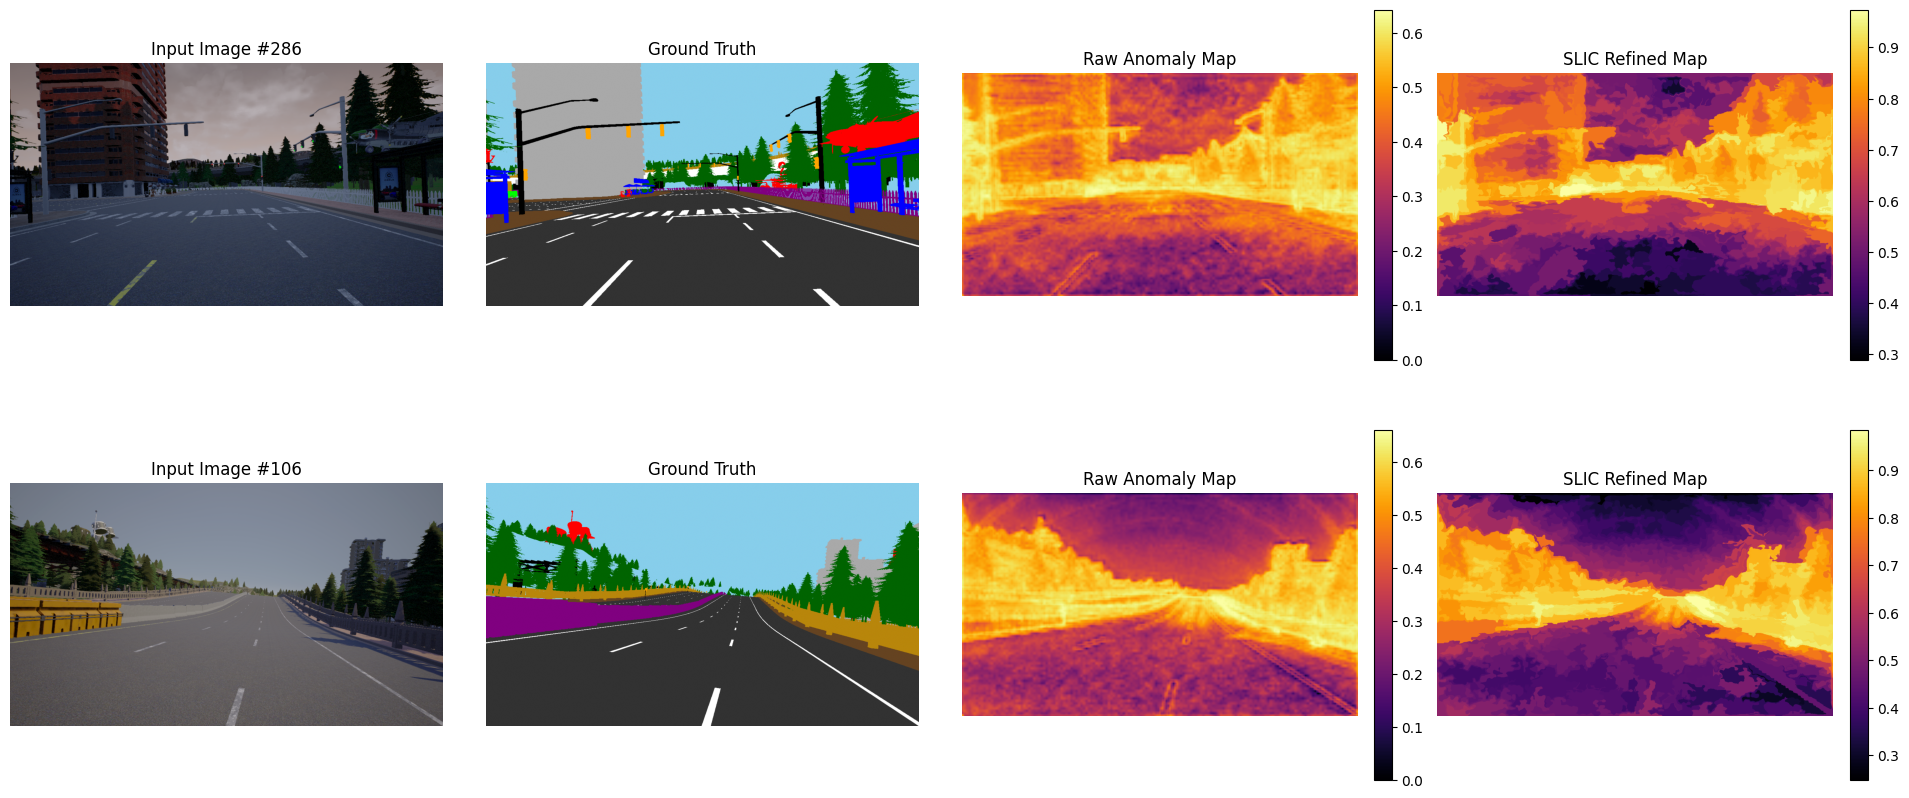




--- Visualizing SLIC Effect: resnext ---
Parameters: n_segments=400, compactness=0.01


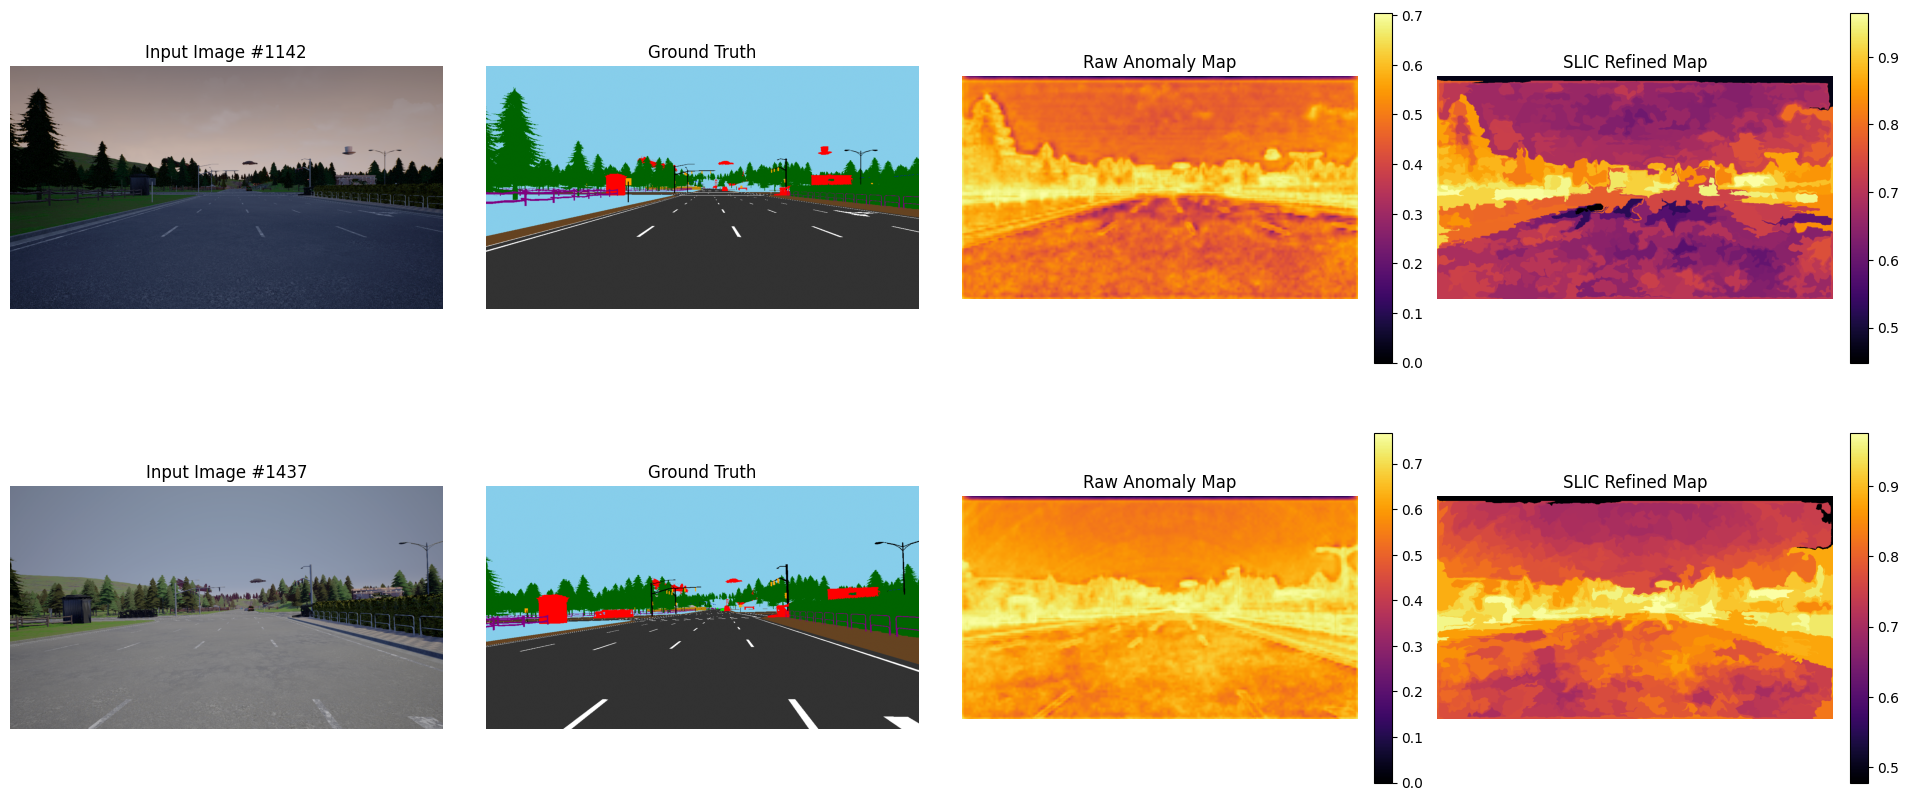




--- Visualizing SLIC Effect: resnet101 ---
Parameters: n_segments=500, compactness=0.01


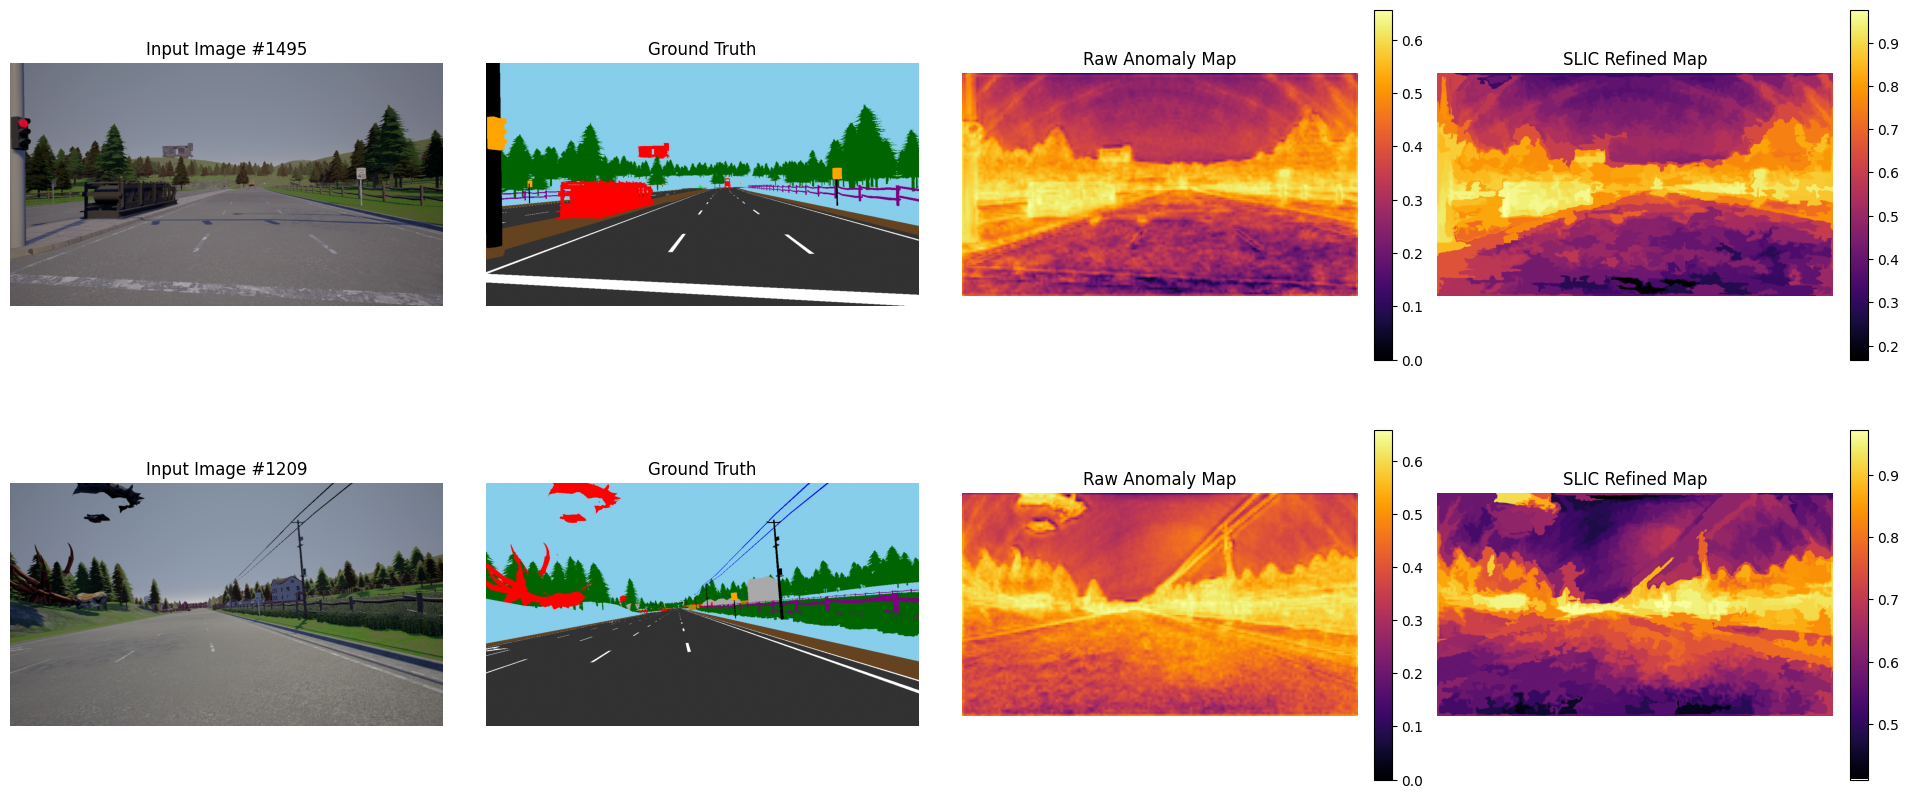




--- Visualizing SLIC Effect: resnext ---
Parameters: n_segments=500, compactness=0.01


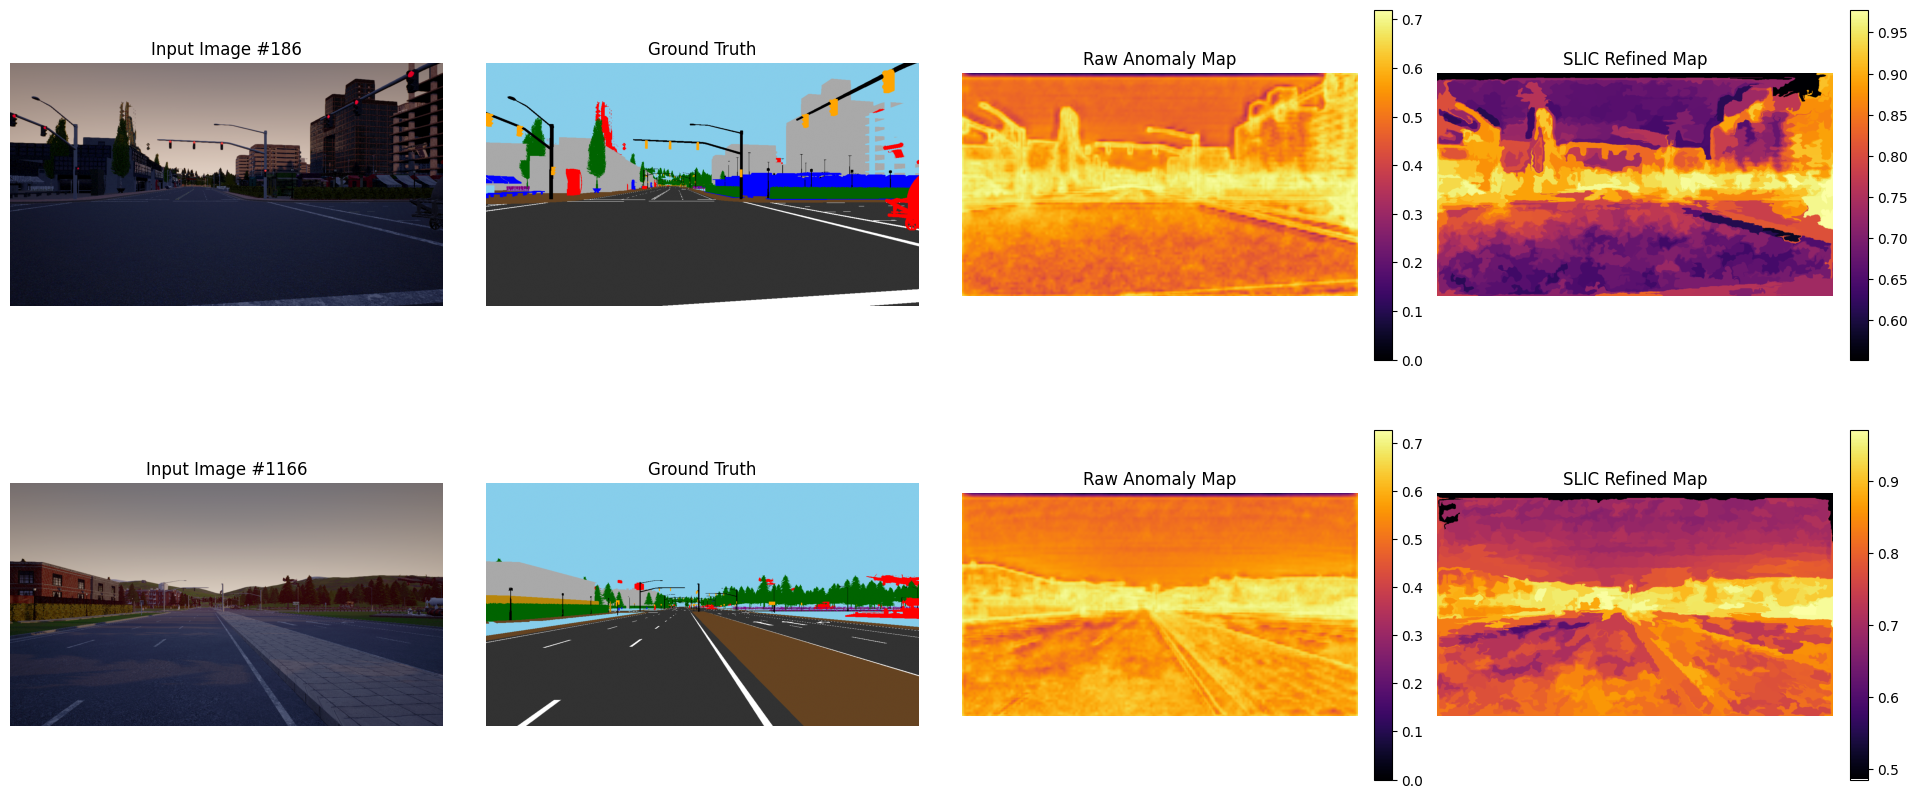

In [ ]:
# @title Qualitative results

def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_slic_effect(model_name, dataloader, device, cmap, N_SEGMENTS=300, COMPACTNESS=0.05, num_samples=3):
    """
    Visualizes the effect of SLIC refinement on OOD Anomaly Maps.
    Plots: Input | Ground Truth | Raw Anomaly Map | SLIC Refined Map
    """

    if model_name not in model_configs:
        print(f"Error: Model '{model_name}' not found.")
        return

    config = model_configs[model_name]
    print(f"--- Visualizing SLIC Effect: {model_name} ---")
    print(f"Parameters: n_segments={N_SEGMENTS}, compactness={COMPACTNESS}")

    try:
        model, weights_path = build_model_configured(model_name, classes=N)
        state_dict = load_state_dict_cpu(weights_path)

        if config.get("use_groupnorm", False):
            keys_to_remove = [k for k in state_dict.keys() if
                              "running_mean" in k or "running_var" in k or "num_batches_tracked" in k]
            if keys_to_remove:
                for k in keys_to_remove: del state_dict[k]

        try:
            model.load_state_dict(state_dict, strict=True)
        except:
            model.load_state_dict(state_dict, strict=False)

        model.eval()
        model = model.to(device)

        prototypes, _ = get_prototypes_for_model(model_name)
        prototypes = prototypes.to(device)

    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Select Random Samples
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(num_samples, 4, figsize=(24, 5 * num_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    ANOMALY_LABEL = 13

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            if len(sample) == 2:
                image, mask = sample
            else:
                image, mask, _ = sample


            image_batch = image.unsqueeze(0).to(device)
            pixel_features = model(image_batch)

            p_close = compute_close_set_prob(pixel_features, prototypes)
            p_close = F.interpolate(p_close, size=mask.shape, mode='bilinear', align_corners=False)
            pixel_features_up = F.interpolate(pixel_features, size=mask.shape, mode='bilinear', align_corners=False)
            mmsp = compute_MMSP(p_close)
            eds = compute_EDS(pixel_features_up, prototypes)
            anomaly_raw = fuse_anomaly_maps(mmsp, eds, beta=20.0, gamma=0.8) # [1, H, W]
            anomaly_np = anomaly_raw.squeeze(0).cpu().numpy()
            norm_min, norm_max = anomaly_np.min(), anomaly_np.max()
            anomaly_norm = (anomaly_np - norm_min) / (norm_max - norm_min + 1e-8)
            # Apply SLIC
            segments = slic(
                img_as_float(anomaly_norm),
                n_segments=N_SEGMENTS,
                compactness=COMPACTNESS,
                start_label=0,
                channel_axis=None
            )

            # Mean per segment
            means = nd_mean(anomaly_norm, labels=segments, index=np.arange(segments.max() + 1))
            anomaly_slic = means[segments] # This is the refined map

            img_disp = denormalize(image).permute(1, 2, 0).numpy()
            img_disp = np.clip(img_disp, 0, 1)
            gt_mask = mask.numpy()
            ax_img = axs[i, 0] if num_samples > 1 else axs[0]
            ax_img.imshow(img_disp)
            ax_img.set_title(f"Input Image #{idx}")
            ax_img.axis("off")
            ax_gt = axs[i, 1] if num_samples > 1 else axs[1]
            ax_gt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=N)
            ax_gt.set_title("Ground Truth")
            ax_gt.axis("off")
            ax_raw = axs[i, 2] if num_samples > 1 else axs[2]
            im_raw = ax_raw.imshow(anomaly_np, cmap='inferno')
            ax_raw.set_title("Raw Anomaly Map")
            ax_raw.axis("off")
            plt.colorbar(im_raw, ax=ax_raw, fraction=0.046, pad=0.04)
            ax_slic = axs[i, 3] if num_samples > 1 else axs[3]
            im_slic = ax_slic.imshow(anomaly_slic, cmap='inferno')
            ax_slic.set_title(f"SLIC Refined Map")
            ax_slic.axis("off")
            plt.colorbar(im_slic, ax=ax_slic, fraction=0.046, pad=0.04)

    plt.show()
    print('\n\n')

    del model, prototypes
    gc.collect()
    torch.cuda.empty_cache()

visualize_slic_effect("resnet101", test_loader, DEVICE, cmap, N_SEGMENTS=400, COMPACTNESS=0.01, num_samples=2)
visualize_slic_effect("resnext", test_loader, DEVICE, cmap,  N_SEGMENTS=400, COMPACTNESS=0.01, num_samples=2)
visualize_slic_effect("resnet101", test_loader, DEVICE, cmap, N_SEGMENTS=500, COMPACTNESS=0.01, num_samples=2)
visualize_slic_effect("resnext", test_loader, DEVICE, cmap,  N_SEGMENTS=500, COMPACTNESS=0.01, num_samples=2)

# 6. CONCLUSIONS


In this project, I explored strategies for semantic segmentation in an open-world context, evaluating both a metric-learning-based formulation and an alternative approach based on cosine similarity. Several insights emerged from this analysis, helping to understand the strengths and limitations of the different methods, and practical considerations when implementing such systems.

## Key Findings

1. **Closed-set segmentation is largely stable across variants**  
   In all experiments (except GN), closed-set mIoU remained in the range 0.53–0.55.  

   This suggests that:  
   - The segmentation backbone is the main driver of accuracy on known classes.  
   - Variants in metric learning primarily affect the geometry of the latent space, with a marginal impact on final segmentation.  
   - Lightweight models such as MobileNetV2 can achieve performance comparable to heavier models, making them suitable for real-time or embedded scenarios.

2. **GroupNorm degraded performance**  
   Replacing BN → GN does not guarantee improvements when working with small batch sizes.

3. **Euclidean distance-based methods outperformed cosine similarity-based methods**  

4. **Introducing a margin worsened OOD detection despite improving class compactness**  


5. **Superpixel post-processing improves anomaly maps, but at the cost of increased computational load**  

## Possible Alternatives and Untreated Ideas

1. **Adaptive or learnable prototype scaling**  

2. **Real-time alternatives to superpixels**  
   To achieve faster refinement of the maps, lightweight edge-aware smoothing methods could be considered, or more sophisticated approaches such as Conditional Random Fields ([Zheng et al., 2015, arXiv:1502.03240](https://arxiv.org/abs/1502.03240)).

3. **Exploring other normalization strategies**  
   Alternatives to BatchNorm and GroupNorm could be tested to improve stability and performance.



# 7. APPENDIX

## Training progress for each model

* **resnet baseline**:

![resnet baseline](https://drive.google.com/uc?id=1nWEQ5LuR4l9ZSGh5Xj59aKJz9QiH4oF1)


* **resnet with prototype magnitude = 5**:

![resnet with prototype magnitude = 5](https://drive.google.com/uc?id=13yVP3AzVzK45U4Z2nWAOmerzkSvt8Cwp)

* **resnet with prototype magnitude = 1**:

![resnet with prototype magnitude = 1](https://drive.google.com/uc?id=1SakyKBbBc8egvZ5MX4vSGlBytzGJZfKq)

* **resnetx**:

![resnetx](https://drive.google.com/uc?id=1gnkr0QhmmznjRZZKbLzhcZ9C5-u-k6lq)

* **mobilenetv2**:

![mobilenetv2](https://drive.google.com/uc?id=1Pt39j1EF9ZTy2vGYZjr8sHgx8SpLh1XA)

* **group norm**:

![group norm](https://drive.google.com/uc?id=1Fdf_R45nMPuRE7_ruAXNvk7EQlDpKvu3)

* **resnet cos scale factor = 20**:

![resnet cos scale factor = 20](https://drive.google.com/uc?id=17PlWn4xcm235Q1uMh3-BG9N_xAWCVrNr)

* **resnet cos scale factor = 10**:

![resnet cos scale factor = 10](https://drive.google.com/uc?id=1Qn2Wiu3LCTgXbsJXzZKQNdEC50nbiLQs)

* **resnet cos scale factor = 10 and margin**:

![resnet cos scale factor = 5.5](https://drive.google.com/uc?id=1UOqltgyX8miYwku3IbYKWIqdLco-BTSa)

## Code used to train models

Losses and functions to compute predictions

In [ ]:
"""
def hybrid_loss(pixel_features, labels, prototypes, lambda_vl=0.01):

    N = pixel_features.shape[1]

    # Flatten features: [B, N, H, W] -> [num_pixels, N]
    features_flat = pixel_features.permute(0, 2, 3, 1).reshape(-1, N)
    labels_flat = labels.reshape(-1)  # Flatten labels to match features

    # --- Efficient squared Euclidean distances ---
    # ||f - m||^2 = ||f||^2 - 2<f, m> + ||m||^2
    feat_sq = (features_flat ** 2).sum(dim=1, keepdim=True)      # [P, 1]
    proto_sq = (prototypes ** 2).sum(dim=1).unsqueeze(0)         # [1, N]
    feat_dot_proto = torch.matmul(features_flat, prototypes.t()) # [P, N]
    dists_sq = feat_sq - 2 * feat_dot_proto + proto_sq           # [P, N]

    # --- Logits for cross-entropy ---
    logits_flat = -dists_sq  # negative distance as logits

    # --- Discriminative Cross Entropy Loss (LDCE) ---
    loss_dce = F.cross_entropy(logits_flat, labels_flat)

    # --- Variance Loss (LVL) for attractive force ---
    correct_proto_dists_sq = dists_sq.gather(1, labels_flat.unsqueeze(1)).squeeze(1)
    loss_vl = correct_proto_dists_sq.mean()

    # --- Total Hybrid Loss ---
    loss_total = loss_dce + lambda_vl * loss_vl

    return loss_total, logits_flat


def cosine_loss(pixel_features, labels, prototypes, scale_factor=20.0):

    B, N, H, W = pixel_features.shape

    # --- Normalize features along the channel dimension ---
    # f_normalized = f / ||f||_2
    features_norm = F.normalize(pixel_features, p=2, dim=1)

    # ---  Normalize prototypes along their feature dimension ---
    # p_normalized = p / ||p||_2
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)

    labels_flat = labels.reshape(-1)  # Flatten labels for cross entropy

    # --- Flatten features to match labels ---
    # [B, N, H, W] -> [B, H, W, N] -> [num_pixels, N]
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)

    # --- Cosine similarity between each pixel and each prototype ---
    # [num_pixels, N] x [N, N]^T = [num_pixels, N]
    cos_similarity = torch.matmul(features_flat, prototypes_norm.t())

    # --- Scale logits ---
    # The scale factor makes the softmax more sensitive to differences
    logits = cos_similarity * scale_factor

    # --- 7. Compute cross entropy loss ---
    loss = F.cross_entropy(logits, labels_flat)

    return loss, logits



def cosface_loss (pixel_features, labels, prototypes,
                        scale_factor=SCALE_FACTOR, margin=MARGIN, eps=1e-7):

    device = pixel_features.device
    B, N, H, W = pixel_features.shape
    # --- Normalize features and prototypes ---
    features_norm = F.normalize(pixel_features, p=2, dim=1)  # [B, N, H, W]
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)    # [N, N]
    # --- Flatten features and labels ---
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)  # [B*H*W, N]
    labels_flat = labels.reshape(-1)                                   # [B*H*W]
    # --- Cosine similarity ---
    cos_theta = torch.matmul(features_flat, prototypes_norm.t())       # [num_pixels, N]
    cos_theta = cos_theta.clamp(-1.0 + eps, 1.0 - eps)                 # Clamp for acos
    # --- Average angle (degrees) for metric evaluation ---
    with torch.no_grad():
        target_cosines = cos_theta[torch.arange(labels_flat.size(0)), labels_flat]
        angles = torch.rad2deg(torch.acos(target_cosines))
        avg_angle = angles.mean().item()
    # --- Apply margin ---
    if margin > 0.0:
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels_flat.view(-1, 1), 1.0)
        cos_theta_m = cos_theta - (one_hot * margin)
    else:
        cos_theta_m = cos_theta
    # --- Scale and compute cross-entropy loss ---
    logits = cos_theta_m * scale_factor
    loss = F.cross_entropy(logits, labels_flat)

    return loss, logits, avg_angle



#used during training for hybrid loss
def calculate_probabilities(pixel_features, prototypes):

    B, N, H, W = pixel_features.shape

    # Flatten features to shape [num_pixels, N] for matrix multiplication
    features_flat = pixel_features.permute(0, 2, 3, 1).reshape(-1, N)

    # --- Compute squared Euclidean distances ---
    # ||f - m||^2 = ||f||^2 - 2<f, m> + ||m||^2
    feat_sq = (features_flat ** 2).sum(dim=1, keepdim=True)      # [num_pixels, 1]
    proto_sq = (prototypes ** 2).sum(dim=1).unsqueeze(0)         # [1, N]
    feat_dot_proto = torch.matmul(features_flat, prototypes.t()) # [num_pixels, N]
    dists_sq = feat_sq - 2 * feat_dot_proto + proto_sq           # [num_pixels, N]

    # --- Convert distances to logits for softmax ---
    logits = -dists_sq  # Negative distance: closer = higher logit

    # --- Softmax to get probabilities ---
    probs_flat = F.softmax(logits, dim=1)  # [num_pixels, N]

    # --- Reshape back to image shape [B, N, H, W] ---
    probs = probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)

    return probs


#used during training for cosine loss
def calculate_probabilities(pixel_features, prototypes, scale_factor=20.0):
    B, N, H, W = pixel_features.shape

    # 1. Normalize features along channel dimension (L2 norm)
    features_norm = F.normalize(pixel_features, p=2, dim=1)      # [B, N, H, W]

    # 2. Normalize prototypes (L2 norm)
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)        # [N, N]

    # 3. Reshape features to [B*H*W, N] for matrix multiplication with prototypes
    features_flat = features_norm.permute(0, 2, 3, 1).reshape(-1, N)

    # 4. Compute cosine similarity (dot product of normalized vectors)
    cos_sim = torch.matmul(features_flat, prototypes_norm.t())   # [B*H*W, N]

    # 5. Apply scale factor to logits to sharpen softmax distribution
    logits = cos_sim * scale_factor

    # 6. Compute softmax probabilities along class dimension
    probs_flat = F.softmax(logits, dim=1)

    # 7. Reshape back to original image shape [B, N, H, W]
    probs = probs_flat.reshape(B, H, W, N).permute(0, 3, 1, 2)

    return probs
"""

Training loop

In [ ]:
"""
def train_model(
    model,
    prototypes,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_classes,
    scheduler,
    num_epochs=50,
    patience=5,
    save_dir="/kaggle/working"
):

    best_val_loss = float('inf')
    patience_counter = 0
    save_counter = 0  # Counter for saved models

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_mious, val_mious = [], []

    os.makedirs(save_dir, exist_ok=True)
    prototypes = prototypes.to(device)

    for epoch in range(1, num_epochs + 1):

        # ===== TRAIN =====
        model.train()
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch} [Training]", leave=False)
        running_loss, running_acc, running_miou = 0.0, 0.0, 0.0
        total_pixels, samples_seen = 0, 0

        for images, masks, _ in train_loop:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            pixel_features = model(images)
            _, _, Hf, Wf = pixel_features.shape

            # Resize ground truth to match feature map
            masks_resized = F.interpolate(
                masks.unsqueeze(1).float(), size=(Hf, Wf), mode='nearest'
            ).squeeze(1).long()

            # Compute loss (all pixels valid)
            loss, logits_flat = criterion(pixel_features, masks_resized, prototypes)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            if logits_flat.numel() > 0:
                preds_flat = torch.argmax(logits_flat, dim=1)
                labels_flat = masks_resized.reshape(-1)

                correct = (preds_flat == labels_flat).float().sum().item()
                running_acc += correct
                total_pixels += labels_flat.numel()

                preds_mask = preds_flat.view_as(masks_resized)
                with torch.no_grad():
                    batch_miou = mean_iou(preds_mask, masks_resized, num_classes)
                running_miou += batch_miou * images.size(0)

            samples_seen += images.size(0)
            train_loop.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mIoU": f"{running_miou / max(1, samples_seen):.4f}"
            })

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_acc / total_pixels if total_pixels > 0 else 0.0
        epoch_train_miou = running_miou / len(train_loader.dataset)

        # ===== VALIDATION =====
        model.eval()
        val_loss, val_miou, val_acc = 0.0, 0.0, 0.0
        val_count, correct_val, pixels_val = 0, 0, 0

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch} [Validation]", leave=False)

        with torch.no_grad():
            for images, masks, _ in val_loop:
                images, masks = images.to(device), masks.to(device)
                pixel_features = model(images)
                _, _, Hf, Wf = pixel_features.shape

                masks_resized = F.interpolate(
                    masks.unsqueeze(1).float(), size=(Hf, Wf), mode='nearest'
                ).squeeze(1).long()

                loss, _, _ = criterion(pixel_features, masks_resized, prototypes)
                val_loss += loss.item() * images.size(0)

                probs = calculate_probabilities(pixel_features, prototypes)
                upsampled_probs = F.interpolate(
                    probs, size=masks.shape[1:], mode='bilinear', align_corners=False
                )
                preds = torch.argmax(upsampled_probs, dim=1)

                # All pixels are valid
                correct_val += (preds == masks).sum().item()
                pixels_val += masks.numel()

                batch_miou = mean_iou(preds, masks, num_classes)
                val_miou += batch_miou * images.size(0)
                val_count += images.size(0)

                val_loop.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "mIoU": f"{val_miou / max(1, val_count):.4f}"
                })

        epoch_val_loss = val_loss / val_count
        epoch_val_acc = correct_val / pixels_val if pixels_val > 0 else 0.0
        epoch_val_miou = val_miou / val_count

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        train_mious.append(epoch_train_miou)
        val_mious.append(epoch_val_miou)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}/{num_epochs} "
              f"| LR: {current_lr:.6f} "
              f"| Train → Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, mIoU: {epoch_train_miou:.4f} "
              f"| Val → Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}, mIoU: {epoch_val_miou:.4f}")

        # Scheduler update
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)
        else:
            scheduler.step()

        # ===== SAVE BEST MODEL =====
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            save_counter += 1

            save_path = os.path.join(save_dir, f"best_model_weights_{save_counter}.pth")
            torch.save(model.state_dict(), save_path)

            print(f"✓ Saved new best weights: {save_path} (Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping after {epoch} epochs (no improvement).")
                break

    # ===== PLOT RESULTS =====
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend(); plt.title("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label="Train Pixel Acc")
    plt.plot(val_accs, label="Val Pixel Acc")
    plt.legend(); plt.title("Pixel Accuracy")

    plt.subplot(1, 3, 3)
    plt.plot(train_mious, label="Train mIoU")
    plt.plot(val_mious, label="Val mIoU")
    plt.legend(); plt.title("Mean IoU")

    plt.tight_layout()
    plt.show()

    print(f"✓ Training completed. Weights saved in: {save_dir}")
"""


In [ ]:
"""
criterion = hybrid_loss
WEIGHT_DECAY = 0.01
LEARNING_RATE = 1e-4
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=0)
"""

In [ ]:
"""
train_model(
    model=model,
    prototypes=prototypes,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterio=criterion,
    device=DEVICE,
    num_classes=N,
    scheduler=scheduler,
    num_epochs=50,
    patience=3,
    ignore_index=255 # O il tuo ignore index
)
"""

group norm transform

In [ ]:
"""
import torch
import torch.nn as nn
from math import gcd

def _adjust_num_groups(num_groups, num_channels):
    if num_groups <= 0:
        return 1
    if num_groups > num_channels:
        num_groups = num_channels
    while num_groups > 1 and (num_channels % num_groups != 0):
        num_groups -= 1
    return max(1, num_groups)

def convert_batchnorm_modules(module, num_groups=32, layer_norm=False):
    for name, child in list(module.named_children()):
        # Recurse first
        convert_batchnorm_modules(child, num_groups=num_groups, layer_norm=layer_norm)

        # Replace BatchNorm2d and SyncBatchNorm
        if isinstance(child, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            num_channels = child.num_features
            if layer_norm:
                ng = 1
            else:
                ng = _adjust_num_groups(num_groups, num_channels)

            # Create GroupNorm with same eps and affine=True
            gn = nn.GroupNorm(num_groups=ng, num_channels=num_channels, eps=child.eps, affine=True)

            # If original had affine params, copy them (weight & bias)
            if child.affine:
                with torch.no_grad():
                    # BatchNorm weight/bias shape: [C]
                    if hasattr(child, 'weight') and child.weight is not None:
                        gn.weight.data.copy_(child.weight.data)
                        gn.weight.requires_grad = child.weight.requires_grad
                    if hasattr(child, 'bias') and child.bias is not None:
                        gn.bias.data.copy_(child.bias.data)
                        gn.bias.requires_grad = child.bias.requires_grad

            # Replace the module in the parent
            setattr(module, name, gn)

def convert_bn_to_gn(model, num_groups=32, layer_norm=False):
    convert_batchnorm_modules(model, num_groups=num_groups, layer_norm=layer_norm)
    return model

model = convert_bn_to_gn(model, num_groups=32, layer_norm=False).to(DEVICE)
"""